In [196]:
import datetime
import os
import io

import pandas as pd
import opendatasets as od
from sklearn.model_selection import train_test_split, KFold
import sklearn.metrics as metrics
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score,
    roc_auc_score,
    accuracy_score,
    mean_squared_log_error, 
    mean_absolute_percentage_error
)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import shap
from scipy import stats

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from optuna.samplers import TPESampler
import optuna
import json
import logging

logging.getLogger('lightgbm').setLevel(logging.ERROR)

%matplotlib inline
pd.set_option('display.float_format', '{:.5f}'.format)

In [2]:
# path = 'https://www.kaggle.com/competitions/playground-series-s4e3/'
# od.download(path)

In [266]:
train_df_original = pd.read_csv('./playground-series-s4e3/train.csv').drop(columns=['id'])
test_df_original = pd.read_csv('./playground-series-s4e3/test.csv').drop(columns=['id'])
subm_df = pd.read_csv('./playground-series-s4e3/sample_submission.csv')

In [267]:
additional_df = pd.read_csv("./playground-series-s4e3/Faults.NNA", sep="\t", header=None)

In [268]:
additional_df.columns = ['X_Minimum','X_Maximum','Y_Minimum','Y_Maximum','Pixels_Areas','X_Perimeter','Y_Perimeter','Sum_of_Luminosity','Minimum_of_Luminosity','Maximum_of_Luminosity','Length_of_Conveyer','TypeOfSteel_A300','TypeOfSteel_A400','Steel_Plate_Thickness','Edges_Index','Empty_Index','Square_Index','Outside_X_Index','Edges_X_Index','Edges_Y_Index','Outside_Global_Index','LogOfAreas','Log_X_Index','Log_Y_Index','Orientation_Index','Luminosity_Index','SigmoidOfAreas','Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']

In [270]:
train_df_original.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.50000,-0.01040,0.14170,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.74190,-0.29970,0.94910,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.01050,-0.09440,1.00000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.66670,-0.04020,0.40250,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.91580,-0.24550,0.99980,0,0,0,0,0,0,1


In [271]:
additional_df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.81820,-0.29130,0.58220,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.79310,-0.17560,0.29840,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.66670,-0.12280,0.21500,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.84440,-0.15680,0.52120,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.93380,-0.19920,1.00000,1,0,0,0,0,0,0


In [272]:
train_df_original = pd.concat([train_df_original, additional_df])

In [273]:
train_df_original.head().T

,0,1,2,3,4
X_Minimum,584.00000,808.00000,39.00000,781.00000,1540.00000
X_Maximum,590.00000,816.00000,192.00000,789.00000,1560.00000
Y_Minimum,909972.00000,728350.00000,2212076.00000,3353146.00000,618457.00000
Y_Maximum,909977.00000,728372.00000,2212144.00000,3353173.00000,618502.00000
Pixels_Areas,16.00000,433.00000,11388.00000,210.00000,521.00000
X_Perimeter,8.00000,20.00000,705.00000,16.00000,72.00000
Y_Perimeter,5.00000,54.00000,420.00000,29.00000,67.00000
Sum_of_Luminosity,2274.00000,44478.00000,1311391.00000,3202.00000,48231.00000
Minimum_of_Luminosity,113.00000,70.00000,29.00000,114.00000,82.00000
Maximum_of_Luminosity,140.00000,111.00000,141.00000,134.00000,111.00000


In [274]:
subm_df.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000
1,19220,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000
2,19221,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000
3,19222,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000
4,19223,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000,0.50000


In [275]:
TARGETS = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']
TRAIN_FEATURES = [feat for feat in train_df_original.columns if feat not in TARGETS]

## EDA

In [276]:
train_df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21160 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              21160 non-null  int64  
 1   X_Maximum              21160 non-null  int64  
 2   Y_Minimum              21160 non-null  int64  
 3   Y_Maximum              21160 non-null  int64  
 4   Pixels_Areas           21160 non-null  int64  
 5   X_Perimeter            21160 non-null  int64  
 6   Y_Perimeter            21160 non-null  int64  
 7   Sum_of_Luminosity      21160 non-null  int64  
 8   Minimum_of_Luminosity  21160 non-null  int64  
 9   Maximum_of_Luminosity  21160 non-null  int64  
 10  Length_of_Conveyer     21160 non-null  int64  
 11  TypeOfSteel_A300       21160 non-null  int64  
 12  TypeOfSteel_A400       21160 non-null  int64  
 13  Steel_Plate_Thickness  21160 non-null  int64  
 14  Edges_Index            21160 non-null  float64
 15  Empty_In

In [277]:
train_df_original.isna().any()

X_Minimum                False
X_Maximum                False
Y_Minimum                False
Y_Maximum                False
Pixels_Areas             False
X_Perimeter              False
Y_Perimeter              False
Sum_of_Luminosity        False
Minimum_of_Luminosity    False
Maximum_of_Luminosity    False
Length_of_Conveyer       False
TypeOfSteel_A300         False
TypeOfSteel_A400         False
Steel_Plate_Thickness    False
Edges_Index              False
Empty_Index              False
Square_Index             False
Outside_X_Index          False
Edges_X_Index            False
Edges_Y_Index            False
Outside_Global_Index     False
LogOfAreas               False
Log_X_Index              False
Log_Y_Index              False
Orientation_Index        False
Luminosity_Index         False
SigmoidOfAreas           False
Pastry                   False
Z_Scratch                False
K_Scatch                 False
Stains                   False
Dirtiness                False
Bumps   

In [10]:
test_df_original.isna().any()

X_Minimum                False
X_Maximum                False
Y_Minimum                False
Y_Maximum                False
Pixels_Areas             False
X_Perimeter              False
Y_Perimeter              False
Sum_of_Luminosity        False
Minimum_of_Luminosity    False
Maximum_of_Luminosity    False
Length_of_Conveyer       False
TypeOfSteel_A300         False
TypeOfSteel_A400         False
Steel_Plate_Thickness    False
Edges_Index              False
Empty_Index              False
Square_Index             False
Outside_X_Index          False
Edges_X_Index            False
Edges_Y_Index            False
Outside_Global_Index     False
LogOfAreas               False
Log_X_Index              False
Log_Y_Index              False
Orientation_Index        False
Luminosity_Index         False
SigmoidOfAreas           False
dtype: bool

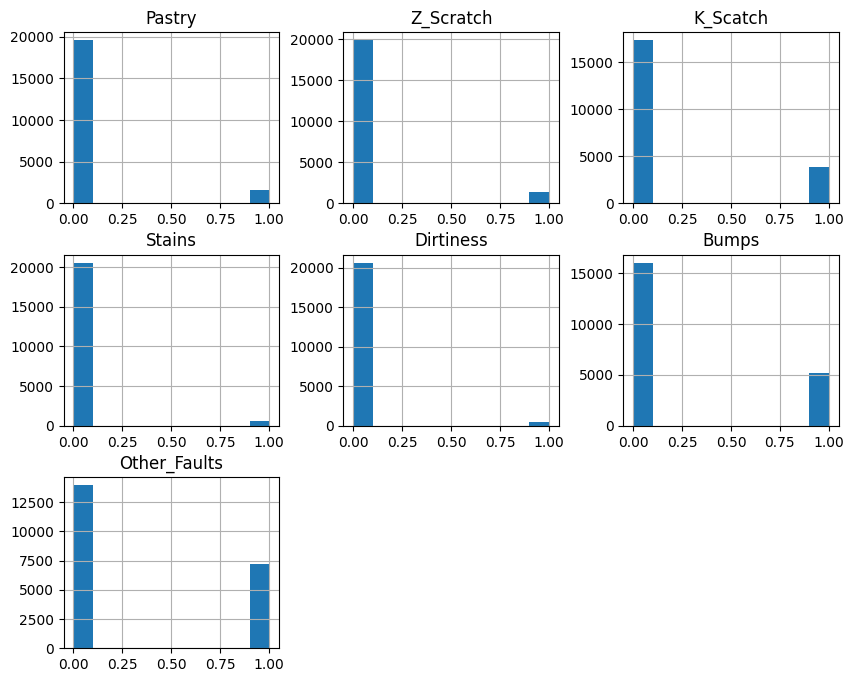

In [278]:
train_df_original[TARGETS].hist(figsize=(10,8));

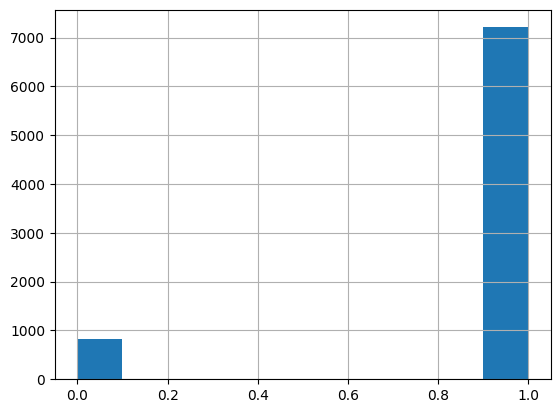

In [279]:
train_df_original[train_df_original[train_df_original.columns[-7:-1]].sum(axis=1)==0].Other_Faults.hist();

In [281]:
train_df_original_eda = train_df_original.copy()

In [282]:
train_df_original_eda.corr()[TARGETS]

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
X_Minimum,0.11998,-0.12353,-0.50172,0.04776,0.04949,0.20788,0.16844
X_Maximum,0.10906,-0.14408,-0.43108,0.03817,0.04299,0.18967,0.15201
Y_Minimum,-0.01107,-0.01881,0.00909,-0.04207,0.00069,0.06288,-0.02494
Y_Maximum,-0.01176,-0.01949,0.00972,-0.04363,-0.00107,0.06304,-0.02433
Pixels_Areas,-0.09763,-0.08174,0.67970,-0.07620,-0.05285,-0.21567,-0.19337
X_Perimeter,-0.09826,-0.06706,0.63225,-0.08059,-0.04745,-0.20372,-0.17668
Y_Perimeter,-0.04109,-0.04053,0.40920,-0.06556,-0.01333,-0.14724,-0.11553
Sum_of_Luminosity,-0.09209,-0.06420,0.63774,-0.07456,-0.04758,-0.20436,-0.18666
Minimum_of_Luminosity,-0.01192,0.05953,-0.57352,0.16875,0.07900,0.12887,0.21070
Maximum_of_Luminosity,-0.08232,-0.09150,0.12967,0.11267,0.02079,-0.06774,-0.00816


In [171]:
other_faults_df = train_df_original[(train_df_original.Other_Faults == 1) & (np.sum(train_df_original[TARGETS[:-1]], axis=1)==0)]

In [172]:
other_faults_df.shape

(6540, 34)

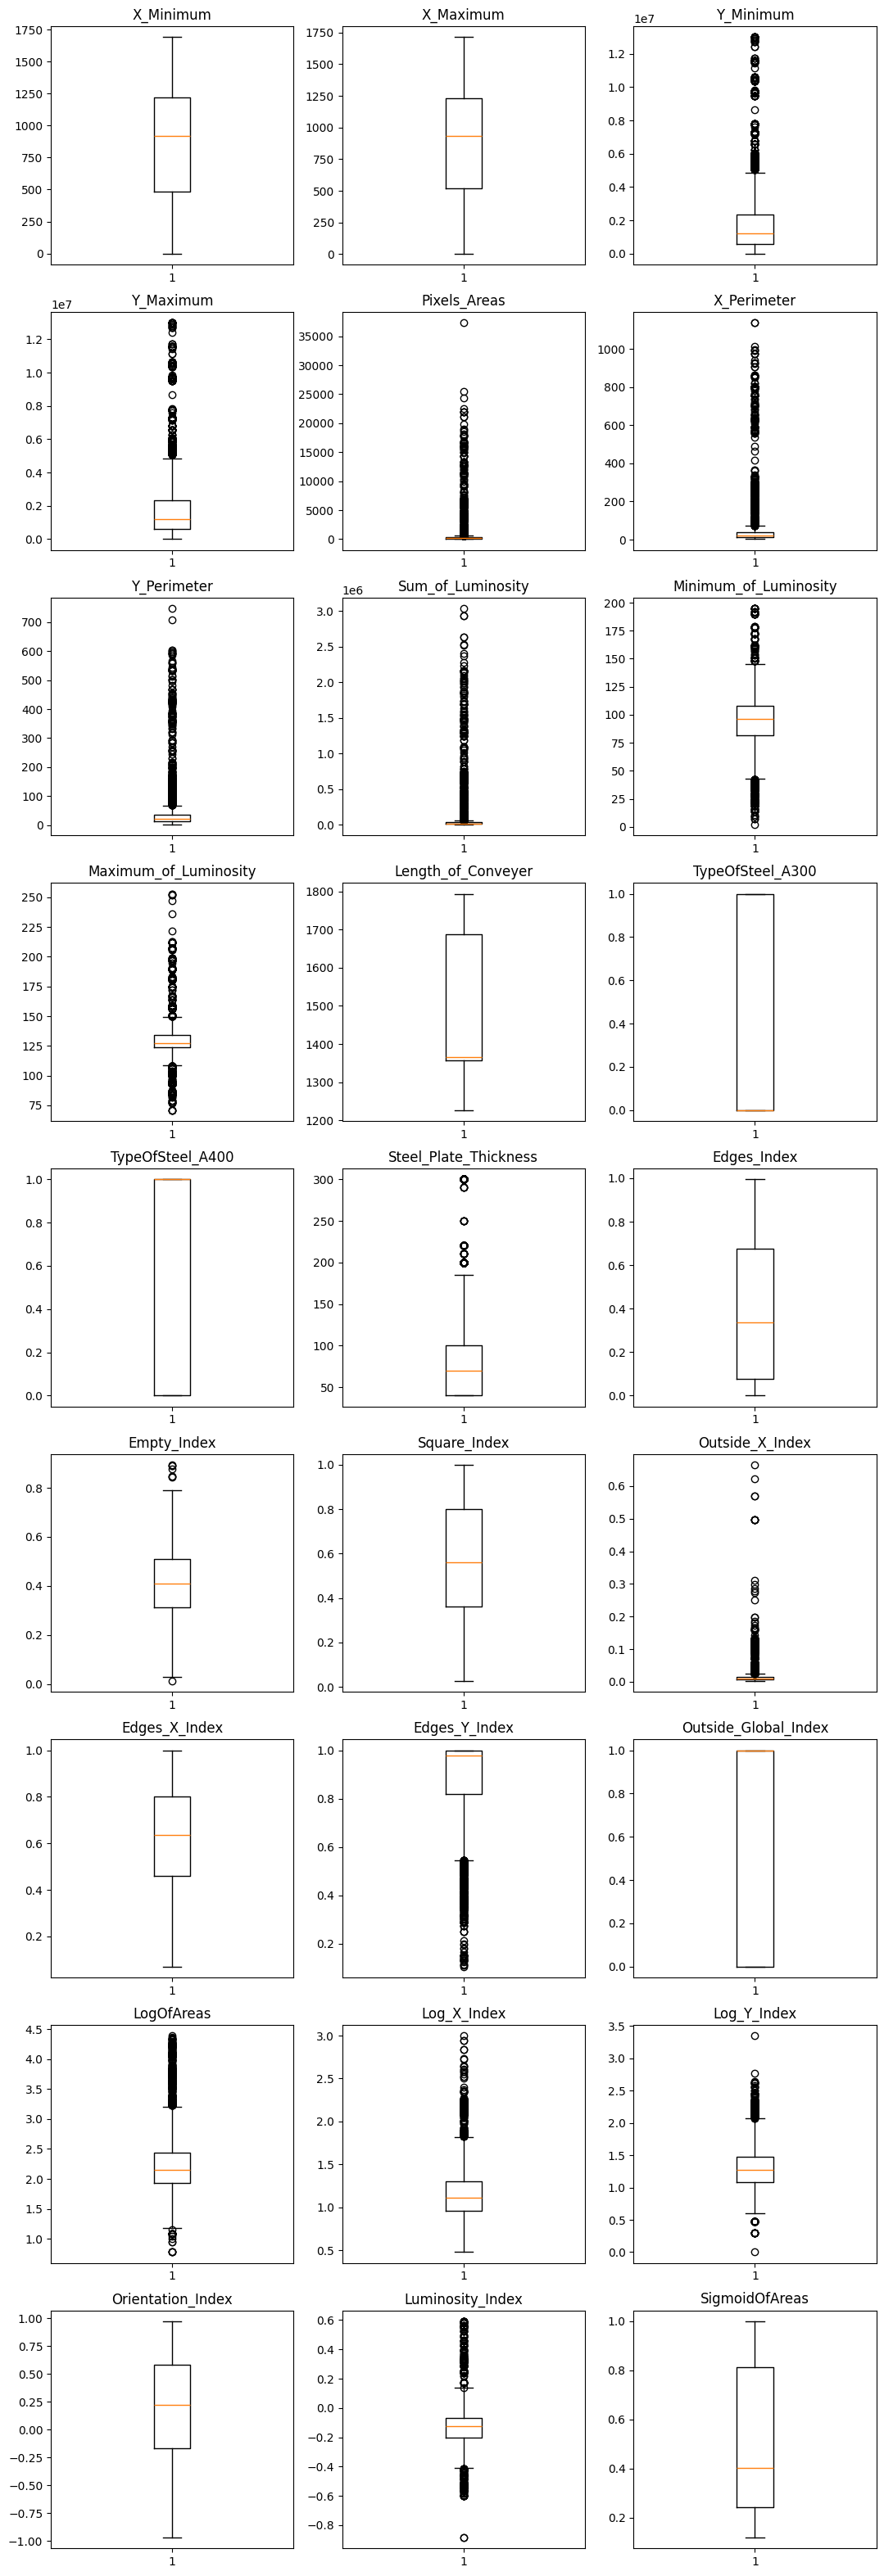

In [173]:
fig, axes = plt.subplots(round(len(TRAIN_FEATURES)/3), 3, figsize=(13,40))

for i, col in enumerate(TRAIN_FEATURES):
    axes[int(i/3), i%3].boxplot(other_faults_df[col])
    axes[int(i/3), i%3].set_title(col)

outliers are visible in 
1. luminosity_Index 
2. Log_Y_Index
3. Empty_index
4. Pixel_areas
5. sum_of_luminosity
6. x_perimeter
7. y_perimeter

let's check it with scipy

In [175]:
threshold = 5.8
train_df_exclude_outliers = pd.DataFrame()

print(other_faults_df.shape)
for i, col in enumerate(TRAIN_FEATURES):    
    z = np.abs(stats.zscore(other_faults_df[col]))
    outliers = train_df_original.iloc[other_faults_df[z > threshold].index]
    if outliers.shape[0] > 0:
        print(col, end=': ')
        print(outliers.shape)

(6540, 34)
Pixels_Areas: (59, 34)
X_Perimeter: (72, 34)
Y_Perimeter: (70, 34)
Sum_of_Luminosity: (62, 34)
Maximum_of_Luminosity: (7, 34)
Outside_X_Index: (17, 34)
Log_Y_Index: (1, 34)


In [178]:
threshold = 5.8
train_df_exclude_outliers = pd.DataFrame()

outliers_dfs = pd.DataFrame()

for i, col in enumerate(TRAIN_FEATURES):    
    z = np.abs(stats.zscore(other_faults_df[col]))
    outliers = train_df_original.iloc[other_faults_df[z > threshold].index]
    outliers_dfs = pd.concat([outliers_dfs, outliers]).drop_duplicates()
    if outliers.shape[0] > 0:
        print(col)
        display(outliers.head())

Pixels_Areas


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
400,1641,1677,464503,464538,13309,976,534,1339579,42,148,...,0.91630,-0.53730,1.00000,0,0,0,0,0,0,1
1331,0,33,819301,819496,16584,928,597,1847464,23,141,...,-0.06860,-0.08210,1.00000,0,0,0,0,0,0,1
2460,39,907,908650,908829,13387,851,425,132331,48,222,...,-0.94720,-0.22480,1.00000,0,0,0,0,0,0,1
2470,41,222,592614,592819,17887,713,448,2156667,27,143,...,0.01160,-0.07880,1.00000,0,0,0,0,0,0,1
2942,39,218,4639210,4639275,16052,562,343,1835252,27,127,...,-0.11670,-0.18740,1.00000,0,0,0,0,0,0,1


X_Perimeter


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
400,1641,1677,464503,464538,13309,976,534,1339579,42,148,...,0.91630,-0.53730,1.00000,0,0,0,0,0,0,1
586,39,192,877413,877428,12012,756,388,1383987,29,141,...,0.11650,-0.09730,1.00000,0,0,0,0,0,0,1
1331,0,33,819301,819496,16584,928,597,1847464,23,141,...,-0.06860,-0.08210,1.00000,0,0,0,0,0,0,1
1879,39,191,983156,983171,11221,801,503,1245388,119,143,...,0.07690,-0.01920,1.00000,0,0,0,0,0,0,1
2460,39,907,908650,908829,13387,851,425,132331,48,222,...,-0.94720,-0.22480,1.00000,0,0,0,0,0,0,1


Y_Perimeter


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
400,1641,1677,464503,464538,13309,976,534,1339579,42,148,...,0.91630,-0.53730,1.00000,0,0,0,0,0,0,1
1331,0,33,819301,819496,16584,928,597,1847464,23,141,...,-0.06860,-0.08210,1.00000,0,0,0,0,0,0,1
1879,39,191,983156,983171,11221,801,503,1245388,119,143,...,0.07690,-0.01920,1.00000,0,0,0,0,0,0,1
2436,1465,1668,544375,544389,10166,625,418,1096472,37,141,...,0.14840,-0.10590,1.00000,0,0,0,0,0,0,1
2460,39,907,908650,908829,13387,851,425,132331,48,222,...,-0.94720,-0.22480,1.00000,0,0,0,0,0,0,1


Sum_of_Luminosity


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
1331,0,33,819301,819496,16584,928,597,1847464,23,141,...,-0.06860,-0.08210,1.00000,0,0,0,0,0,0,1
1800,1,226,2368032,2368203,12718,558,348,1689009,96,141,...,0.04760,-0.10580,1.00000,0,0,0,0,0,0,1
2470,41,222,592614,592819,17887,713,448,2156667,27,143,...,0.01160,-0.07880,1.00000,0,0,0,0,0,0,1
2595,39,71,1679793,1679864,170,51,29,2155986,115,133,...,-0.44160,-0.03660,0.70650,0,0,0,0,0,0,1
2942,39,218,4639210,4639275,16052,562,343,1835252,27,127,...,-0.11670,-0.18740,1.00000,0,0,0,0,0,0,1


Maximum_of_Luminosity


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
2460,39,907,908650,908829,13387,851,425,132331,48,222,...,-0.94720,-0.22480,1.00000,0,0,0,0,0,0,1
5826,828,836,2488529,2488541,16,6,8,1990,97,252,...,-0.11110,-0.08280,0.17730,0,0,0,0,0,0,1
6044,867,882,675316,675327,75,20,7,8132,102,247,...,-0.33330,-0.10910,0.20180,0,0,0,0,0,0,1
11624,501,544,404729,404761,463,31,44,47204,49,253,...,0.91380,-0.14390,0.71740,0,0,0,0,0,0,1
15770,0,14,971696,971813,706,37,118,76438,81,252,...,0.92410,-0.14870,0.99980,0,0,0,0,0,0,1


Outside_X_Index


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
635,54,91,1506506,1506552,60,8,59,79713,89,166,...,-0.94670,-0.18350,0.99750,0,0,0,0,0,0,1
1500,482,922,9716963,971728,1071,239,138,112240,70,119,...,-0.84090,-0.24980,1.00000,0,0,0,0,0,0,1
1692,435,734,712491,712528,8035,417,106,93355,119,143,...,-0.53730,-0.01930,1.00000,0,0,0,0,0,0,1
2460,39,907,908650,908829,13387,851,425,132331,48,222,...,-0.94720,-0.22480,1.00000,0,0,0,0,0,0,1
2754,1420,1668,2191536,2191539,873,333,61,95390,77,167,...,-0.95590,-0.21480,1.00000,0,0,0,0,0,0,1


Log_Y_Index


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
3436,41,226,1157189,1157378,16164,926,591,1847157,23,143,...,0.93710,-0.08850,1.00000,0,0,0,0,0,0,1


In [179]:
outliers_dfs

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
400,1641,1677,464503,464538,13309,976,534,1339579,42,148,...,0.91630,-0.53730,1.00000,0,0,0,0,0,0,1
1331,0,33,819301,819496,16584,928,597,1847464,23,141,...,-0.06860,-0.08210,1.00000,0,0,0,0,0,0,1
2460,39,907,908650,908829,13387,851,425,132331,48,222,...,-0.94720,-0.22480,1.00000,0,0,0,0,0,0,1
2470,41,222,592614,592819,17887,713,448,2156667,27,143,...,0.01160,-0.07880,1.00000,0,0,0,0,0,0,1
2942,39,218,4639210,4639275,16052,562,343,1835252,27,127,...,-0.11670,-0.18740,1.00000,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,1420,1668,2191536,2191539,873,333,61,95390,77,167,...,-0.95590,-0.21480,1.00000,0,0,0,0,0,0,1
4689,41,734,143167,143219,5543,558,343,622760,56,126,...,-0.63480,-0.15150,1.00000,0,0,0,0,0,0,1
8948,888,914,7300641,7300696,5706,247,133,723207,43,101,...,-0.90630,-0.34680,1.00000,0,0,0,0,0,0,1
10929,39,393,1636571,1636729,10743,538,359,1098162,33,141,...,0.06450,-0.09440,1.00000,0,0,0,0,0,0,1


In [289]:
for target in TARGETS:
    print(target, additional_df[target].value_counts()[1])

Pastry 158
Z_Scratch 190
K_Scatch 391
Stains 72
Dirtiness 55
Bumps 402
Other_Faults 673


In [290]:
for target in TARGETS:
    print(target, train_df_original[target].value_counts()[1])

Pastry 1624
Z_Scratch 1340
K_Scatch 3823
Stains 640
Dirtiness 540
Bumps 5165
Other_Faults 7231


In [16]:
train_df_original = train_df_original_eda.copy()

## TRAINING

In [291]:
train_df_original[TARGETS].sum(axis=1).value_counts()

1    20321
0      818
2       21
Name: count, dtype: int64

In [292]:
def print_metrics(y_true, y_predicted):
    func = [accuracy_score]
    for f in func:
        print(f'{f.__name__}: {f(y_true, y_predicted)}')

In [293]:
def train_model(X_train, y_train, X_test, y_test, model):
    model.fit(
        X_train,
        y_train
    )

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    print_metrics(y_train, pred_train)
    print_metrics(y_test, pred_test)
    
    return model

In [294]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df_original[TRAIN_FEATURES], 
    train_df_original[TARGETS], 
    test_size=0.2, 
    random_state=42
)

In [213]:
models = []

for target in TARGETS:
    model = CatBoostClassifier(silent=True)
    print(f'{"="*20}{target}{"="*20}')
    models.append(train_model(
        X_train, 
        y_train[target],
        X_test, 
        y_test[target],
        model
    ))

====================Pastry====================
accuracy_score: 0.9596747967479675
accuracy_score: 0.9232570239334027
====================Z_Scratch====================
accuracy_score: 0.9882276422764228
accuracy_score: 0.95369406867846
====================K_Scatch====================
accuracy_score: 0.9826991869918699
accuracy_score: 0.9648803329864725
====================Stains====================
accuracy_score: 0.999869918699187
accuracy_score: 0.981009365244537
====================Dirtiness====================
accuracy_score: 0.9884227642276423
accuracy_score: 0.97840790842872
====================Bumps====================
accuracy_score: 0.871869918699187
accuracy_score: 0.7780957336108221
====================Other_Faults====================
accuracy_score: 0.8073495934959349
accuracy_score: 0.6779396462018731


metrics with additional dataset have become better

====================Pastry====================  
accuracy_score: 0.9608341209829868  
accuracy_score: 0.9248582230623819  
====================Z_Scratch====================  
accuracy_score: 0.9878308128544423  
accuracy_score: 0.9560491493383743  
====================K_Scatch====================  
accuracy_score: 0.9831049149338374  
accuracy_score: 0.9629017013232514  
====================Stains====================  
accuracy_score: 0.9997637051039697  
accuracy_score: 0.9848771266540642  
====================Dirtiness====================  
accuracy_score: 0.989898393194707  
accuracy_score: 0.9780245746691871  
====================Bumps====================  
accuracy_score: 0.875413516068053  
accuracy_score: 0.7946597353497165  
====================Other_Faults====================  
accuracy_score: 0.8145085066162571  
accuracy_score: 0.6873818525519849  

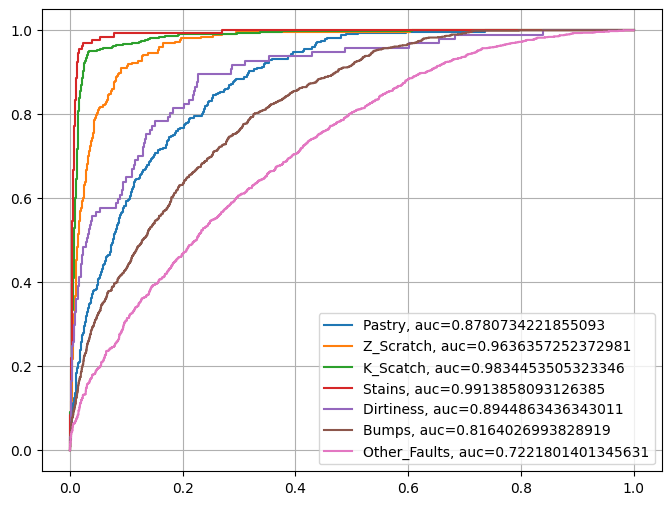

In [296]:
# baseline catboost with the additional data

fig = plt.figure(figsize=(8,6))

results = pd.DataFrame()

for i, target in enumerate(TARGETS):
    y_true = y_test[target]
    y_pred_proba = models[i].predict_proba(X_test)[::,1]
    results[target] = y_pred_proba
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_proba)
    auc = metrics.roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr,tpr,label=f"{target}, auc={auc}")
    plt.legend(loc=4)

plt.grid()
plt.show();

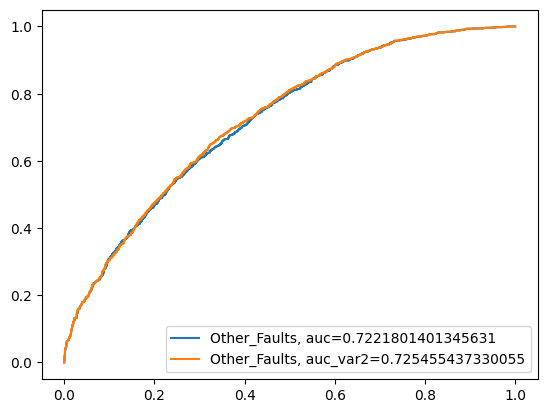

In [298]:
y_true = y_test[TARGETS[-1]]
y_pred_proba = models[-1].predict_proba(X_test)[::,1]

y_pred_proba_var2 = results.apply(
    lambda row: row['Other_Faults']**1.05 if np.sum(row[TARGETS[:-1]]) >= 0.51 else row['Other_Faults']**0.95, 
    axis=1
)

fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_proba)
fpr_var2, tpr_var2, _ = metrics.roc_curve(y_true, y_pred_proba_var2)

auc = metrics.roc_auc_score(y_true, y_pred_proba)
auc_var2 = metrics.roc_auc_score(y_true, y_pred_proba_var2)
plt.plot(fpr,tpr,label=f"{TARGETS[-1]}, auc={auc}")
plt.plot(fpr_var2,tpr_var2,label=f"{TARGETS[-1]}, auc_var2={auc_var2}")
plt.legend(loc=4)

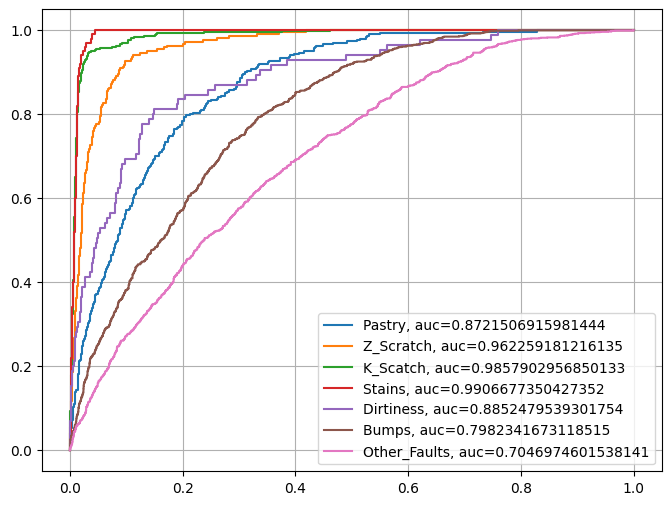

In [214]:
# baseline catboost

fig = plt.figure(figsize=(8,6))

results = pd.DataFrame()

for i, target in enumerate(TARGETS):
    y_true = y_test[target]
    y_pred_proba = models[i].predict_proba(X_test)[::,1]
    results[target] = y_pred_proba
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_proba)
    auc = metrics.roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr,tpr,label=f"{target}, auc={auc}")
    plt.legend(loc=4)

plt.grid()
plt.show();

In [305]:
def objective(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        'objective': 'binary',
        "metric": "AUC",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 1,
        'verbose': -1,
        "num_leaves": trial.suggest_int("num_leaves", 70, 200), 
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.03),
        "n_estimators": trial.suggest_int("n_estimators", 400, 550),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.007, 0.017),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.05),
        "max_depth": trial.suggest_int("max_depth", 6, 14),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 0.7),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 50)
    }
    
    lgbm_classifier = LGBMClassifier(**param)
    
    lgbm_classifier.fit(X_train, y_train)
    score = lgbm_classifier.score(X_test, y_test)
    
    y_pred = lgbm_classifier.predict_proba(X_test)[::,1]
    ROC_AUC_Score = roc_auc_score(y_test, y_pred)
    print('ROC AUC Score of LightGBM =', ROC_AUC_Score)
    
    return ROC_AUC_Score

In [323]:
models_lgbm = []
best_params_list = []

for target in TARGETS:
    print(f'{"="*20}{target}{"="*20}')
    
    sampler = optuna.samplers.TPESampler(seed=42) 
    
    study = optuna.create_study(direction="maximize", sampler=sampler)    
    study.optimize(
        lambda trial: 
            objective(
                trial, 
                X_train, 
                y_train[target], 
                X_test, 
                y_test[target]
            ), 
            n_trials=30
    )

    best_params = study.best_params
    best_params_list.append(best_params)
    
    model = LGBMClassifier(**best_params)
    model.fit(
        train_df_original[TRAIN_FEATURES], 
        train_df_original[target]
    )
    models_lgbm.append(model)

[I 2024-03-04 16:28:35,510] A new study created in memory with name: no-name-377d44a4-5217-4d09-9bfe-56e0068b521b


====================Pastry====================


[I 2024-03-04 16:28:35,952] Trial 0 finished with value: 0.8776500770440502 and parameters: {'num_leaves': 119, 'learning_rate': 0.028767857660247902, 'n_estimators': 510, 'lambda_l1': 0.012986584841970367, 'lambda_l2': 0.0246805592132731, 'max_depth': 7, 'colsample_bytree': 0.13485016730091967, 'subsample': 0.9598528437324805, 'min_child_samples': 38}. Best is trial 0 with value: 0.8776500770440502.


ROC AUC Score of LightGBM = 0.8776500770440502


[I 2024-03-04 16:28:36,634] Trial 1 finished with value: 0.8812814728916141 and parameters: {'num_leaves': 162, 'learning_rate': 0.005514612357395061, 'n_estimators': 546, 'lambda_l1': 0.01532442640800422, 'lambda_l2': 0.026370173320348286, 'max_depth': 7, 'colsample_bytree': 0.2100427059120603, 'subsample': 0.7912726728878613, 'min_child_samples': 36}. Best is trial 1 with value: 0.8812814728916141.


ROC AUC Score of LightGBM = 0.8812814728916141


[I 2024-03-04 16:28:37,564] Trial 2 finished with value: 0.881251290686407 and parameters: {'num_leaves': 126, 'learning_rate': 0.012280728504951047, 'n_estimators': 492, 'lambda_l1': 0.008394938606520418, 'lambda_l2': 0.028764339456056547, 'max_depth': 9, 'colsample_bytree': 0.3736419905302215, 'subsample': 0.935552788417904, 'min_child_samples': 26}. Best is trial 1 with value: 0.8812814728916141.


ROC AUC Score of LightGBM = 0.881251290686407


[I 2024-03-04 16:28:37,920] Trial 3 finished with value: 0.8805483630125018 and parameters: {'num_leaves': 137, 'learning_rate': 0.01981036422155106, 'n_estimators': 407, 'lambda_l1': 0.013075448519014385, 'lambda_l2': 0.025115723710618747, 'max_depth': 6, 'colsample_bytree': 0.6693313223519999, 'subsample': 0.9896896099223678, 'min_child_samples': 45}. Best is trial 1 with value: 0.8812814728916141.


ROC AUC Score of LightGBM = 0.8805483630125018


[I 2024-03-04 16:28:38,626] Trial 4 finished with value: 0.8758804466966371 and parameters: {'num_leaves': 109, 'learning_rate': 0.007441802850159596, 'n_estimators': 503, 'lambda_l1': 0.011401524937396015, 'lambda_l2': 0.023661147045343365, 'max_depth': 10, 'colsample_bytree': 0.12063311266913104, 'subsample': 0.9727961206236346, 'min_child_samples': 28}. Best is trial 1 with value: 0.8812814728916141.


ROC AUC Score of LightGBM = 0.8758804466966371


[I 2024-03-04 16:28:39,653] Trial 5 finished with value: 0.878836714269829 and parameters: {'num_leaves': 156, 'learning_rate': 0.012792776902235273, 'n_estimators': 478, 'lambda_l1': 0.012467102793432798, 'lambda_l2': 0.025545633665765812, 'max_depth': 14, 'colsample_bytree': 0.5650796940166687, 'subsample': 0.9818496824692567, 'min_child_samples': 47}. Best is trial 1 with value: 0.8812814728916141.


ROC AUC Score of LightGBM = 0.878836714269829


[I 2024-03-04 16:28:40,101] Trial 6 finished with value: 0.8772521484964497 and parameters: {'num_leaves': 148, 'learning_rate': 0.028046855875577918, 'n_estimators': 413, 'lambda_l1': 0.008959828624191452, 'lambda_l2': 0.021356818667316143, 'max_depth': 8, 'colsample_bytree': 0.3332063738136892, 'subsample': 0.7814047095321688, 'min_child_samples': 45}. Best is trial 1 with value: 0.8812814728916141.


ROC AUC Score of LightGBM = 0.8772521484964497


[I 2024-03-04 16:28:40,576] Trial 7 finished with value: 0.8783657130148846 and parameters: {'num_leaves': 116, 'learning_rate': 0.012023362742184518, 'n_estimators': 481, 'lambda_l1': 0.008409242249747626, 'lambda_l2': 0.04406590942262119, 'max_depth': 6, 'colsample_bytree': 0.6921321619603104, 'subsample': 0.9316734307889972, 'min_child_samples': 26}. Best is trial 1 with value: 0.8812814728916141.


ROC AUC Score of LightGBM = 0.8783657130148846


[I 2024-03-04 16:28:40,954] Trial 8 finished with value: 0.8800328827183047 and parameters: {'num_leaves': 70, 'learning_rate': 0.025386535711370853, 'n_estimators': 506, 'lambda_l1': 0.014290071680409876, 'lambda_l2': 0.04313811040057837, 'max_depth': 6, 'colsample_bytree': 0.31507943712656356, 'subsample': 0.7347607178575388, 'min_child_samples': 46}. Best is trial 1 with value: 0.8812814728916141.


ROC AUC Score of LightGBM = 0.8800328827183047


[I 2024-03-04 16:28:42,019] Trial 9 finished with value: 0.8785460119775699 and parameters: {'num_leaves': 151, 'learning_rate': 0.01327245062131623, 'n_estimators': 409, 'lambda_l1': 0.010109823217156623, 'lambda_l2': 0.02975549966080241, 'max_depth': 12, 'colsample_bytree': 0.48253448281312783, 'subsample': 0.9661638227728979, 'min_child_samples': 34}. Best is trial 1 with value: 0.8812814728916141.


ROC AUC Score of LightGBM = 0.8785460119775699


[I 2024-03-04 16:28:43,306] Trial 10 finished with value: 0.8815523184699212 and parameters: {'num_leaves': 196, 'learning_rate': 0.005149929573895429, 'n_estimators': 546, 'lambda_l1': 0.016525808108507505, 'lambda_l2': 0.036371548402466466, 'max_depth': 12, 'colsample_bytree': 0.2532660752591193, 'subsample': 0.8212078216055934, 'min_child_samples': 36}. Best is trial 10 with value: 0.8815523184699212.


ROC AUC Score of LightGBM = 0.8815523184699212


[I 2024-03-04 16:28:44,542] Trial 11 finished with value: 0.8804482851741832 and parameters: {'num_leaves': 200, 'learning_rate': 0.00521049179884591, 'n_estimators': 546, 'lambda_l1': 0.016712151502523146, 'lambda_l2': 0.036154956655288964, 'max_depth': 12, 'colsample_bytree': 0.21996386753399816, 'subsample': 0.8390775565963364, 'min_child_samples': 36}. Best is trial 10 with value: 0.8815523184699212.


ROC AUC Score of LightGBM = 0.8804482851741832


[I 2024-03-04 16:28:45,881] Trial 12 finished with value: 0.8799542501310542 and parameters: {'num_leaves': 196, 'learning_rate': 0.007489869636038142, 'n_estimators': 546, 'lambda_l1': 0.01698659007320852, 'lambda_l2': 0.03782527184830101, 'max_depth': 12, 'colsample_bytree': 0.2089831918775954, 'subsample': 0.8422848047996623, 'min_child_samples': 40}. Best is trial 10 with value: 0.8815523184699212.


ROC AUC Score of LightGBM = 0.8799542501310542


[I 2024-03-04 16:28:47,045] Trial 13 finished with value: 0.8785007386697591 and parameters: {'num_leaves': 174, 'learning_rate': 0.018778053265789137, 'n_estimators': 531, 'lambda_l1': 0.01509966127696543, 'lambda_l2': 0.032507738249825016, 'max_depth': 14, 'colsample_bytree': 0.24493295978820392, 'subsample': 0.7927401874913584, 'min_child_samples': 31}. Best is trial 10 with value: 0.8815523184699212.


ROC AUC Score of LightGBM = 0.8785007386697591


[I 2024-03-04 16:28:48,175] Trial 14 finished with value: 0.880093247128719 and parameters: {'num_leaves': 178, 'learning_rate': 0.005167209219057948, 'n_estimators': 525, 'lambda_l1': 0.015348392593068678, 'lambda_l2': 0.04984882636308439, 'max_depth': 11, 'colsample_bytree': 0.4352791498259886, 'subsample': 0.8835424881991469, 'min_child_samples': 41}. Best is trial 10 with value: 0.8815523184699212.


ROC AUC Score of LightGBM = 0.880093247128719


[I 2024-03-04 16:28:49,095] Trial 15 finished with value: 0.8826364950517069 and parameters: {'num_leaves': 175, 'learning_rate': 0.009486757776032272, 'n_estimators': 447, 'lambda_l1': 0.015507854781691702, 'lambda_l2': 0.03999398349960997, 'max_depth': 9, 'colsample_bytree': 0.27666273072904113, 'subsample': 0.7030197256937518, 'min_child_samples': 32}. Best is trial 15 with value: 0.8826364950517069.


ROC AUC Score of LightGBM = 0.8826364950517069


[I 2024-03-04 16:28:50,025] Trial 16 finished with value: 0.879623834410891 and parameters: {'num_leaves': 183, 'learning_rate': 0.009706035095405064, 'n_estimators': 446, 'lambda_l1': 0.014028174196597387, 'lambda_l2': 0.04025219421406141, 'max_depth': 10, 'colsample_bytree': 0.28933798449138115, 'subsample': 0.708165707917359, 'min_child_samples': 20}. Best is trial 15 with value: 0.8826364950517069.


ROC AUC Score of LightGBM = 0.879623834410891


[I 2024-03-04 16:28:50,735] Trial 17 finished with value: 0.8810630490381408 and parameters: {'num_leaves': 185, 'learning_rate': 0.015924883451962836, 'n_estimators': 448, 'lambda_l1': 0.01608796441300347, 'lambda_l2': 0.04468611534159342, 'max_depth': 9, 'colsample_bytree': 0.4040657541230003, 'subsample': 0.7326361548666476, 'min_child_samples': 32}. Best is trial 15 with value: 0.8826364950517069.


ROC AUC Score of LightGBM = 0.8810630490381408


[I 2024-03-04 16:28:51,768] Trial 18 finished with value: 0.8787914409620181 and parameters: {'num_leaves': 96, 'learning_rate': 0.021694811239602315, 'n_estimators': 451, 'lambda_l1': 0.011327456111804916, 'lambda_l2': 0.033332345675468805, 'max_depth': 13, 'colsample_bytree': 0.4917308015835322, 'subsample': 0.7589264970603191, 'min_child_samples': 22}. Best is trial 15 with value: 0.8826364950517069.


ROC AUC Score of LightGBM = 0.8787914409620181


[I 2024-03-04 16:28:52,603] Trial 19 finished with value: 0.8780186176550014 and parameters: {'num_leaves': 165, 'learning_rate': 0.009780238212963595, 'n_estimators': 430, 'lambda_l1': 0.014299637309408166, 'lambda_l2': 0.03983900602349256, 'max_depth': 11, 'colsample_bytree': 0.15793924620756367, 'subsample': 0.869977984337478, 'min_child_samples': 29}. Best is trial 15 with value: 0.8826364950517069.


ROC AUC Score of LightGBM = 0.8780186176550014


[I 2024-03-04 16:28:53,264] Trial 20 finished with value: 0.8802076218010835 and parameters: {'num_leaves': 191, 'learning_rate': 0.014665728309724693, 'n_estimators': 469, 'lambda_l1': 0.015890960043737967, 'lambda_l2': 0.047843086046986186, 'max_depth': 9, 'colsample_bytree': 0.290592738563331, 'subsample': 0.7034862884882658, 'min_child_samples': 50}. Best is trial 15 with value: 0.8826364950517069.


ROC AUC Score of LightGBM = 0.8802076218010835


[I 2024-03-04 16:28:54,055] Trial 21 finished with value: 0.8814069673237915 and parameters: {'num_leaves': 169, 'learning_rate': 0.007620139118454564, 'n_estimators': 532, 'lambda_l1': 0.015039015812761508, 'lambda_l2': 0.03486881659334609, 'max_depth': 8, 'colsample_bytree': 0.19592936490565566, 'subsample': 0.8098005140886184, 'min_child_samples': 35}. Best is trial 15 with value: 0.8826364950517069.


ROC AUC Score of LightGBM = 0.8814069673237915


[I 2024-03-04 16:28:54,915] Trial 22 finished with value: 0.8803887150323266 and parameters: {'num_leaves': 169, 'learning_rate': 0.009453686721356913, 'n_estimators': 526, 'lambda_l1': 0.016084136744386874, 'lambda_l2': 0.035262430735298056, 'max_depth': 8, 'colsample_bytree': 0.17028971636338264, 'subsample': 0.8056709652254862, 'min_child_samples': 34}. Best is trial 15 with value: 0.8826364950517069.


ROC AUC Score of LightGBM = 0.8803887150323266


[I 2024-03-04 16:28:55,680] Trial 23 finished with value: 0.8834426776381631 and parameters: {'num_leaves': 144, 'learning_rate': 0.00770113599340266, 'n_estimators': 464, 'lambda_l1': 0.007183121980905116, 'lambda_l2': 0.039725039179295055, 'max_depth': 8, 'colsample_bytree': 0.25669451217111416, 'subsample': 0.828267736172155, 'min_child_samples': 41}. Best is trial 23 with value: 0.8834426776381631.


ROC AUC Score of LightGBM = 0.8834426776381631


[I 2024-03-04 16:28:56,631] Trial 24 finished with value: 0.8818017187971596 and parameters: {'num_leaves': 142, 'learning_rate': 0.010566201204452366, 'n_estimators': 462, 'lambda_l1': 0.007632277113968664, 'lambda_l2': 0.0409433849689007, 'max_depth': 10, 'colsample_bytree': 0.2591383397992108, 'subsample': 0.8761808254311736, 'min_child_samples': 41}. Best is trial 23 with value: 0.8834426776381631.


ROC AUC Score of LightGBM = 0.8818017187971596


[I 2024-03-04 16:28:57,395] Trial 25 finished with value: 0.8821011580435577 and parameters: {'num_leaves': 139, 'learning_rate': 0.010434308829912583, 'n_estimators': 463, 'lambda_l1': 0.007350941507335296, 'lambda_l2': 0.041453067552583156, 'max_depth': 9, 'colsample_bytree': 0.3452345468252727, 'subsample': 0.8939298988463845, 'min_child_samples': 41}. Best is trial 23 with value: 0.8834426776381631.


ROC AUC Score of LightGBM = 0.8821011580435577


[I 2024-03-04 16:28:57,944] Trial 26 finished with value: 0.8815618496926181 and parameters: {'num_leaves': 135, 'learning_rate': 0.01580571726148363, 'n_estimators': 431, 'lambda_l1': 0.007054725147279816, 'lambda_l2': 0.041929995692820465, 'max_depth': 7, 'colsample_bytree': 0.33676726067391055, 'subsample': 0.9064885953360629, 'min_child_samples': 43}. Best is trial 23 with value: 0.8834426776381631.


ROC AUC Score of LightGBM = 0.8815618496926181


[I 2024-03-04 16:28:58,632] Trial 27 finished with value: 0.8822322123556418 and parameters: {'num_leaves': 93, 'learning_rate': 0.007940171307336055, 'n_estimators': 433, 'lambda_l1': 0.009789478980234636, 'lambda_l2': 0.0462514411025651, 'max_depth': 9, 'colsample_bytree': 0.37484357513860683, 'subsample': 0.9063578267318382, 'min_child_samples': 39}. Best is trial 23 with value: 0.8834426776381631.


ROC AUC Score of LightGBM = 0.8822322123556418


[I 2024-03-04 16:28:59,267] Trial 28 finished with value: 0.8816476306968913 and parameters: {'num_leaves': 87, 'learning_rate': 0.007965685883679076, 'n_estimators': 430, 'lambda_l1': 0.009822242948574743, 'lambda_l2': 0.04611301149808112, 'max_depth': 8, 'colsample_bytree': 0.42527252655244985, 'subsample': 0.9261740190204338, 'min_child_samples': 38}. Best is trial 23 with value: 0.8834426776381631.


ROC AUC Score of LightGBM = 0.8816476306968913


[I 2024-03-04 16:28:59,759] Trial 29 finished with value: 0.8815284904131785 and parameters: {'num_leaves': 101, 'learning_rate': 0.014264181304029948, 'n_estimators': 437, 'lambda_l1': 0.00996528100822394, 'lambda_l2': 0.03830760387338491, 'max_depth': 7, 'colsample_bytree': 0.3725330109407099, 'subsample': 0.7569619370874336, 'min_child_samples': 38}. Best is trial 23 with value: 0.8834426776381631.


ROC AUC Score of LightGBM = 0.8815284904131785
[LightGBM] [Warning] lambda_l2 is set=0.039725039179295055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039725039179295055
[LightGBM] [Warning] lambda_l1 is set=0.007183121980905116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007183121980905116
[LightGBM] [Warning] lambda_l2 is set=0.039725039179295055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039725039179295055
[LightGBM] [Warning] lambda_l1 is set=0.007183121980905116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007183121980905116
[LightGBM] [Info] Number of positive: 1624, number of negative: 19536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number o

[I 2024-03-04 16:29:00,578] A new study created in memory with name: no-name-db288b09-45d6-435e-a55a-fe69e7a72dad


====================Z_Scratch====================


[I 2024-03-04 16:29:01,034] Trial 0 finished with value: 0.9584128228836273 and parameters: {'num_leaves': 119, 'learning_rate': 0.028767857660247902, 'n_estimators': 510, 'lambda_l1': 0.012986584841970367, 'lambda_l2': 0.0246805592132731, 'max_depth': 7, 'colsample_bytree': 0.13485016730091967, 'subsample': 0.9598528437324805, 'min_child_samples': 38}. Best is trial 0 with value: 0.9584128228836273.


ROC AUC Score of LightGBM = 0.9584128228836273


[I 2024-03-04 16:29:01,733] Trial 1 finished with value: 0.9542569336345157 and parameters: {'num_leaves': 162, 'learning_rate': 0.005514612357395061, 'n_estimators': 546, 'lambda_l1': 0.01532442640800422, 'lambda_l2': 0.026370173320348286, 'max_depth': 7, 'colsample_bytree': 0.2100427059120603, 'subsample': 0.7912726728878613, 'min_child_samples': 36}. Best is trial 0 with value: 0.9584128228836273.


ROC AUC Score of LightGBM = 0.9542569336345157


[I 2024-03-04 16:29:02,670] Trial 2 finished with value: 0.9624692282783831 and parameters: {'num_leaves': 126, 'learning_rate': 0.012280728504951047, 'n_estimators': 492, 'lambda_l1': 0.008394938606520418, 'lambda_l2': 0.028764339456056547, 'max_depth': 9, 'colsample_bytree': 0.3736419905302215, 'subsample': 0.935552788417904, 'min_child_samples': 26}. Best is trial 2 with value: 0.9624692282783831.


ROC AUC Score of LightGBM = 0.9624692282783831


[I 2024-03-04 16:29:03,146] Trial 3 finished with value: 0.9621629740600727 and parameters: {'num_leaves': 137, 'learning_rate': 0.01981036422155106, 'n_estimators': 407, 'lambda_l1': 0.013075448519014385, 'lambda_l2': 0.025115723710618747, 'max_depth': 6, 'colsample_bytree': 0.6693313223519999, 'subsample': 0.9896896099223678, 'min_child_samples': 45}. Best is trial 2 with value: 0.9624692282783831.


ROC AUC Score of LightGBM = 0.9621629740600727


[I 2024-03-04 16:29:03,865] Trial 4 finished with value: 0.948613663229597 and parameters: {'num_leaves': 109, 'learning_rate': 0.007441802850159596, 'n_estimators': 503, 'lambda_l1': 0.011401524937396015, 'lambda_l2': 0.023661147045343365, 'max_depth': 10, 'colsample_bytree': 0.12063311266913104, 'subsample': 0.9727961206236346, 'min_child_samples': 28}. Best is trial 2 with value: 0.9624692282783831.


ROC AUC Score of LightGBM = 0.948613663229597


[I 2024-03-04 16:29:04,892] Trial 5 finished with value: 0.9611944694779633 and parameters: {'num_leaves': 156, 'learning_rate': 0.012792776902235273, 'n_estimators': 478, 'lambda_l1': 0.012467102793432798, 'lambda_l2': 0.025545633665765812, 'max_depth': 14, 'colsample_bytree': 0.5650796940166687, 'subsample': 0.9818496824692567, 'min_child_samples': 47}. Best is trial 2 with value: 0.9624692282783831.


ROC AUC Score of LightGBM = 0.9611944694779633


[I 2024-03-04 16:29:05,367] Trial 6 finished with value: 0.9615173043386664 and parameters: {'num_leaves': 148, 'learning_rate': 0.028046855875577918, 'n_estimators': 413, 'lambda_l1': 0.008959828624191452, 'lambda_l2': 0.021356818667316143, 'max_depth': 8, 'colsample_bytree': 0.3332063738136892, 'subsample': 0.7814047095321688, 'min_child_samples': 45}. Best is trial 2 with value: 0.9624692282783831.


ROC AUC Score of LightGBM = 0.9615173043386664


[I 2024-03-04 16:29:05,893] Trial 7 finished with value: 0.9618420898631804 and parameters: {'num_leaves': 116, 'learning_rate': 0.012023362742184518, 'n_estimators': 481, 'lambda_l1': 0.008409242249747626, 'lambda_l2': 0.04406590942262119, 'max_depth': 6, 'colsample_bytree': 0.6921321619603104, 'subsample': 0.9316734307889972, 'min_child_samples': 26}. Best is trial 2 with value: 0.9624692282783831.


ROC AUC Score of LightGBM = 0.9618420898631804


[I 2024-03-04 16:29:06,315] Trial 8 finished with value: 0.9616460481501855 and parameters: {'num_leaves': 70, 'learning_rate': 0.025386535711370853, 'n_estimators': 506, 'lambda_l1': 0.014290071680409876, 'lambda_l2': 0.04313811040057837, 'max_depth': 6, 'colsample_bytree': 0.31507943712656356, 'subsample': 0.7347607178575388, 'min_child_samples': 46}. Best is trial 2 with value: 0.9624692282783831.


ROC AUC Score of LightGBM = 0.9616460481501855


[I 2024-03-04 16:29:07,260] Trial 9 finished with value: 0.9627823098200318 and parameters: {'num_leaves': 151, 'learning_rate': 0.01327245062131623, 'n_estimators': 409, 'lambda_l1': 0.010109823217156623, 'lambda_l2': 0.02975549966080241, 'max_depth': 12, 'colsample_bytree': 0.48253448281312783, 'subsample': 0.9661638227728979, 'min_child_samples': 34}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9627823098200318


[I 2024-03-04 16:29:08,493] Trial 10 finished with value: 0.9618742758160602 and parameters: {'num_leaves': 195, 'learning_rate': 0.019768135641918736, 'n_estimators': 438, 'lambda_l1': 0.010468508914066218, 'lambda_l2': 0.035075936530243886, 'max_depth': 13, 'colsample_bytree': 0.49262591366245195, 'subsample': 0.8856154096282642, 'min_child_samples': 31}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9618742758160602


[I 2024-03-04 16:29:09,659] Trial 11 finished with value: 0.9616645794563891 and parameters: {'num_leaves': 180, 'learning_rate': 0.013527331950404226, 'n_estimators': 453, 'lambda_l1': 0.007200412362423255, 'lambda_l2': 0.033030688152692333, 'max_depth': 12, 'colsample_bytree': 0.4250898498418532, 'subsample': 0.9027571855210262, 'min_child_samples': 20}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9616645794563891


[I 2024-03-04 16:29:10,448] Trial 12 finished with value: 0.9620517862228516 and parameters: {'num_leaves': 90, 'learning_rate': 0.016436403386425144, 'n_estimators': 446, 'lambda_l1': 0.009900458929924402, 'lambda_l2': 0.0324967134883142, 'max_depth': 10, 'colsample_bytree': 0.520697557236256, 'subsample': 0.8530182254524145, 'min_child_samples': 21}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9620517862228516


[I 2024-03-04 16:29:11,626] Trial 13 finished with value: 0.9614821923900704 and parameters: {'num_leaves': 130, 'learning_rate': 0.009280097461940213, 'n_estimators': 540, 'lambda_l1': 0.016993624386415516, 'lambda_l2': 0.030393330231270117, 'max_depth': 11, 'colsample_bytree': 0.3916164573838252, 'subsample': 0.9205986807209625, 'min_child_samples': 32}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9614821923900704


[I 2024-03-04 16:29:12,378] Trial 14 finished with value: 0.9611281469083929 and parameters: {'num_leaves': 172, 'learning_rate': 0.016377559888439204, 'n_estimators': 427, 'lambda_l1': 0.007062279574840896, 'lambda_l2': 0.03893253030616896, 'max_depth': 9, 'colsample_bytree': 0.2429125356674716, 'subsample': 0.850522877170666, 'min_child_samples': 41}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9611281469083929


[I 2024-03-04 16:29:13,320] Trial 15 finished with value: 0.9619269437389543 and parameters: {'num_leaves': 96, 'learning_rate': 0.009830478138629802, 'n_estimators': 460, 'lambda_l1': 0.008940802558175547, 'lambda_l2': 0.029456258969661274, 'max_depth': 12, 'colsample_bytree': 0.42932984576704003, 'subsample': 0.938950571776713, 'min_child_samples': 26}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9619269437389543


[I 2024-03-04 16:29:14,318] Trial 16 finished with value: 0.9613846591995256 and parameters: {'num_leaves': 140, 'learning_rate': 0.02098671165677194, 'n_estimators': 526, 'lambda_l1': 0.010700489634749146, 'lambda_l2': 0.036875385710760246, 'max_depth': 10, 'colsample_bytree': 0.6018549995386404, 'subsample': 0.8741970809905124, 'min_child_samples': 32}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9613846591995256


[I 2024-03-04 16:29:15,290] Trial 17 finished with value: 0.9612081241246396 and parameters: {'num_leaves': 129, 'learning_rate': 0.015905154275925877, 'n_estimators': 490, 'lambda_l1': 0.008242486011659726, 'lambda_l2': 0.028799579374922186, 'max_depth': 12, 'colsample_bytree': 0.3443514924254458, 'subsample': 0.9997569630789737, 'min_child_samples': 40}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9612081241246396


[I 2024-03-04 16:29:16,207] Trial 18 finished with value: 0.9625579834817788 and parameters: {'num_leaves': 200, 'learning_rate': 0.010483612465012223, 'n_estimators': 465, 'lambda_l1': 0.009962188270900911, 'lambda_l2': 0.040154865388930074, 'max_depth': 9, 'colsample_bytree': 0.4858886237580286, 'subsample': 0.9447189511928629, 'min_child_samples': 24}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9625579834817788


[I 2024-03-04 16:29:17,911] Trial 19 finished with value: 0.959013627337383 and parameters: {'num_leaves': 200, 'learning_rate': 0.005306397944837929, 'n_estimators': 428, 'lambda_l1': 0.011367762657528535, 'lambda_l2': 0.048748580325146416, 'max_depth': 14, 'colsample_bytree': 0.479578235657391, 'subsample': 0.8254462246846223, 'min_child_samples': 22}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.959013627337383


[I 2024-03-04 16:29:18,843] Trial 20 finished with value: 0.9608813879363147 and parameters: {'num_leaves': 186, 'learning_rate': 0.023402236951187042, 'n_estimators': 458, 'lambda_l1': 0.00987847251188935, 'lambda_l2': 0.039884379997182105, 'max_depth': 11, 'colsample_bytree': 0.6067082317062937, 'subsample': 0.7034862884882658, 'min_child_samples': 50}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9608813879363147


[I 2024-03-04 16:29:19,791] Trial 21 finished with value: 0.9622136913191558 and parameters: {'num_leaves': 167, 'learning_rate': 0.01040192185855195, 'n_estimators': 467, 'lambda_l1': 0.009505317751838119, 'lambda_l2': 0.03289923676749066, 'max_depth': 9, 'colsample_bytree': 0.45968117809589715, 'subsample': 0.9508170880253722, 'min_child_samples': 24}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9622136913191558


[I 2024-03-04 16:29:20,651] Trial 22 finished with value: 0.9622546552591846 and parameters: {'num_leaves': 150, 'learning_rate': 0.01417420780016853, 'n_estimators': 492, 'lambda_l1': 0.0077357338584231, 'lambda_l2': 0.04160358621887081, 'max_depth': 9, 'colsample_bytree': 0.37925469965537356, 'subsample': 0.9069783164920467, 'min_child_samples': 29}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9622546552591846


[I 2024-03-04 16:29:21,511] Trial 23 finished with value: 0.9627267159014212 and parameters: {'num_leaves': 106, 'learning_rate': 0.01125347218040942, 'n_estimators': 519, 'lambda_l1': 0.010586789639526216, 'lambda_l2': 0.04640078704168065, 'max_depth': 8, 'colsample_bytree': 0.5352090153983747, 'subsample': 0.9516628382928259, 'min_child_samples': 24}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9627267159014212


[I 2024-03-04 16:29:22,667] Trial 24 finished with value: 0.9624750802698158 and parameters: {'num_leaves': 98, 'learning_rate': 0.008005572366182151, 'n_estimators': 525, 'lambda_l1': 0.011747878720479759, 'lambda_l2': 0.04770498153958994, 'max_depth': 8, 'colsample_bytree': 0.5450916503890109, 'subsample': 0.9730724359761396, 'min_child_samples': 34}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9624750802698158


[I 2024-03-04 16:29:23,353] Trial 25 finished with value: 0.9612188527755996 and parameters: {'num_leaves': 79, 'learning_rate': 0.01443451709686121, 'n_estimators': 419, 'lambda_l1': 0.010512786202203143, 'lambda_l2': 0.04600581838926206, 'max_depth': 8, 'colsample_bytree': 0.6080520348756779, 'subsample': 0.9551926715254448, 'min_child_samples': 23}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9612188527755996


[I 2024-03-04 16:29:24,342] Trial 26 finished with value: 0.9623209778287551 and parameters: {'num_leaves': 106, 'learning_rate': 0.010530784702913933, 'n_estimators': 403, 'lambda_l1': 0.011203299685553607, 'lambda_l2': 0.04580367252433003, 'max_depth': 11, 'colsample_bytree': 0.5133847733998833, 'subsample': 0.910110359190816, 'min_child_samples': 28}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9623209778287551


[I 2024-03-04 16:29:25,351] Trial 27 finished with value: 0.9626369853661201 and parameters: {'num_leaves': 180, 'learning_rate': 0.007383639412917512, 'n_estimators': 519, 'lambda_l1': 0.009341657968268042, 'lambda_l2': 0.03742003815922333, 'max_depth': 7, 'colsample_bytree': 0.5637867134202529, 'subsample': 0.8858854698600432, 'min_child_samples': 24}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9626369853661201


[I 2024-03-04 16:29:26,352] Trial 28 finished with value: 0.9618928071222638 and parameters: {'num_leaves': 177, 'learning_rate': 0.0072468817094724644, 'n_estimators': 519, 'lambda_l1': 0.0122861614155095, 'lambda_l2': 0.03820963091016342, 'max_depth': 7, 'colsample_bytree': 0.6490143845934901, 'subsample': 0.8200743358687825, 'min_child_samples': 30}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9618928071222638


[I 2024-03-04 16:29:27,064] Trial 29 finished with value: 0.9609623404844668 and parameters: {'num_leaves': 188, 'learning_rate': 0.018430357930702572, 'n_estimators': 532, 'lambda_l1': 0.012942413714751305, 'lambda_l2': 0.036393276794826006, 'max_depth': 7, 'colsample_bytree': 0.5640574619151375, 'subsample': 0.8784714857240103, 'min_child_samples': 37}. Best is trial 9 with value: 0.9627823098200318.


ROC AUC Score of LightGBM = 0.9609623404844668
[LightGBM] [Warning] lambda_l2 is set=0.02975549966080241, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02975549966080241
[LightGBM] [Warning] lambda_l1 is set=0.010109823217156623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010109823217156623
[LightGBM] [Warning] lambda_l2 is set=0.02975549966080241, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02975549966080241
[LightGBM] [Warning] lambda_l1 is set=0.010109823217156623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010109823217156623
[LightGBM] [Info] Number of positive: 1340, number of negative: 19820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of us

[I 2024-03-04 16:29:28,316] A new study created in memory with name: no-name-c485a310-5001-4392-b4bc-1ef06b368954


====================K_Scatch====================


[I 2024-03-04 16:29:28,782] Trial 0 finished with value: 0.9851619678228736 and parameters: {'num_leaves': 119, 'learning_rate': 0.028767857660247902, 'n_estimators': 510, 'lambda_l1': 0.012986584841970367, 'lambda_l2': 0.0246805592132731, 'max_depth': 7, 'colsample_bytree': 0.13485016730091967, 'subsample': 0.9598528437324805, 'min_child_samples': 38}. Best is trial 0 with value: 0.9851619678228736.


ROC AUC Score of LightGBM = 0.9851619678228736


[I 2024-03-04 16:29:29,430] Trial 1 finished with value: 0.9848680395787741 and parameters: {'num_leaves': 162, 'learning_rate': 0.005514612357395061, 'n_estimators': 546, 'lambda_l1': 0.01532442640800422, 'lambda_l2': 0.026370173320348286, 'max_depth': 7, 'colsample_bytree': 0.2100427059120603, 'subsample': 0.7912726728878613, 'min_child_samples': 36}. Best is trial 0 with value: 0.9851619678228736.


ROC AUC Score of LightGBM = 0.9848680395787741


[I 2024-03-04 16:29:30,126] Trial 2 finished with value: 0.9851241770486322 and parameters: {'num_leaves': 126, 'learning_rate': 0.012280728504951047, 'n_estimators': 492, 'lambda_l1': 0.008394938606520418, 'lambda_l2': 0.028764339456056547, 'max_depth': 9, 'colsample_bytree': 0.3736419905302215, 'subsample': 0.935552788417904, 'min_child_samples': 26}. Best is trial 0 with value: 0.9851619678228736.


ROC AUC Score of LightGBM = 0.9851241770486322


[I 2024-03-04 16:29:30,513] Trial 3 finished with value: 0.9853703896686894 and parameters: {'num_leaves': 137, 'learning_rate': 0.01981036422155106, 'n_estimators': 407, 'lambda_l1': 0.013075448519014385, 'lambda_l2': 0.025115723710618747, 'max_depth': 6, 'colsample_bytree': 0.6693313223519999, 'subsample': 0.9896896099223678, 'min_child_samples': 45}. Best is trial 3 with value: 0.9853703896686894.


ROC AUC Score of LightGBM = 0.9853703896686894


[I 2024-03-04 16:29:31,211] Trial 4 finished with value: 0.9849226262526783 and parameters: {'num_leaves': 109, 'learning_rate': 0.007441802850159596, 'n_estimators': 503, 'lambda_l1': 0.011401524937396015, 'lambda_l2': 0.023661147045343365, 'max_depth': 10, 'colsample_bytree': 0.12063311266913104, 'subsample': 0.9727961206236346, 'min_child_samples': 28}. Best is trial 3 with value: 0.9853703896686894.


ROC AUC Score of LightGBM = 0.9849226262526783


[I 2024-03-04 16:29:32,481] Trial 5 finished with value: 0.984574493059667 and parameters: {'num_leaves': 156, 'learning_rate': 0.012792776902235273, 'n_estimators': 478, 'lambda_l1': 0.012467102793432798, 'lambda_l2': 0.025545633665765812, 'max_depth': 14, 'colsample_bytree': 0.5650796940166687, 'subsample': 0.9818496824692567, 'min_child_samples': 47}. Best is trial 3 with value: 0.9853703896686894.


ROC AUC Score of LightGBM = 0.984574493059667


[I 2024-03-04 16:29:33,046] Trial 6 finished with value: 0.9850848593744216 and parameters: {'num_leaves': 148, 'learning_rate': 0.028046855875577918, 'n_estimators': 413, 'lambda_l1': 0.008959828624191452, 'lambda_l2': 0.021356818667316143, 'max_depth': 8, 'colsample_bytree': 0.3332063738136892, 'subsample': 0.7814047095321688, 'min_child_samples': 45}. Best is trial 3 with value: 0.9853703896686894.


ROC AUC Score of LightGBM = 0.9850848593744216


[I 2024-03-04 16:29:33,684] Trial 7 finished with value: 0.9853818414184595 and parameters: {'num_leaves': 116, 'learning_rate': 0.012023362742184518, 'n_estimators': 481, 'lambda_l1': 0.008409242249747626, 'lambda_l2': 0.04406590942262119, 'max_depth': 6, 'colsample_bytree': 0.6921321619603104, 'subsample': 0.9316734307889972, 'min_child_samples': 26}. Best is trial 7 with value: 0.9853818414184595.


ROC AUC Score of LightGBM = 0.9853818414184595


[I 2024-03-04 16:29:34,073] Trial 8 finished with value: 0.9849638525518507 and parameters: {'num_leaves': 70, 'learning_rate': 0.025386535711370853, 'n_estimators': 506, 'lambda_l1': 0.014290071680409876, 'lambda_l2': 0.04313811040057837, 'max_depth': 6, 'colsample_bytree': 0.31507943712656356, 'subsample': 0.7347607178575388, 'min_child_samples': 46}. Best is trial 7 with value: 0.9853818414184595.


ROC AUC Score of LightGBM = 0.9849638525518507


[I 2024-03-04 16:29:35,131] Trial 9 finished with value: 0.9846558004830348 and parameters: {'num_leaves': 151, 'learning_rate': 0.01327245062131623, 'n_estimators': 409, 'lambda_l1': 0.010109823217156623, 'lambda_l2': 0.02975549966080241, 'max_depth': 12, 'colsample_bytree': 0.48253448281312783, 'subsample': 0.9661638227728979, 'min_child_samples': 34}. Best is trial 7 with value: 0.9853818414184595.


ROC AUC Score of LightGBM = 0.9846558004830348


[I 2024-03-04 16:29:36,102] Trial 10 finished with value: 0.983930904722587 and parameters: {'num_leaves': 193, 'learning_rate': 0.020299298069551365, 'n_estimators': 447, 'lambda_l1': 0.007179618756148197, 'lambda_l2': 0.04943212478267911, 'max_depth': 12, 'colsample_bytree': 0.6838226564617748, 'subsample': 0.8872250581517096, 'min_child_samples': 21}. Best is trial 7 with value: 0.9853818414184595.


ROC AUC Score of LightGBM = 0.983930904722587


[I 2024-03-04 16:29:36,614] Trial 11 finished with value: 0.9854478798421338 and parameters: {'num_leaves': 89, 'learning_rate': 0.018343689270243595, 'n_estimators': 448, 'lambda_l1': 0.010999173399538969, 'lambda_l2': 0.036875921079983796, 'max_depth': 6, 'colsample_bytree': 0.6816708087347191, 'subsample': 0.8821552822099676, 'min_child_samples': 41}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9854478798421338


[I 2024-03-04 16:29:37,165] Trial 12 finished with value: 0.9849398038773335 and parameters: {'num_leaves': 88, 'learning_rate': 0.016656638147047563, 'n_estimators': 447, 'lambda_l1': 0.010456937452482667, 'lambda_l2': 0.03827221590301234, 'max_depth': 8, 'colsample_bytree': 0.5631544074280428, 'subsample': 0.8750853297512998, 'min_child_samples': 40}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9849398038773335


[I 2024-03-04 16:29:37,608] Trial 13 finished with value: 0.9852490011211262 and parameters: {'num_leaves': 99, 'learning_rate': 0.009688315785834178, 'n_estimators': 448, 'lambda_l1': 0.016993624386415516, 'lambda_l2': 0.03731211208653857, 'max_depth': 6, 'colsample_bytree': 0.5873196331957236, 'subsample': 0.9064688535850598, 'min_child_samples': 31}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9852490011211262


[I 2024-03-04 16:29:38,301] Trial 14 finished with value: 0.9846935912572762 and parameters: {'num_leaves': 76, 'learning_rate': 0.017339505573131006, 'n_estimators': 466, 'lambda_l1': 0.007100777072213012, 'lambda_l2': 0.0434200705383078, 'max_depth': 10, 'colsample_bytree': 0.48763099544049543, 'subsample': 0.8353533169548902, 'min_child_samples': 21}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9846935912572762


[I 2024-03-04 16:29:38,829] Trial 15 finished with value: 0.9851203597987089 and parameters: {'num_leaves': 102, 'learning_rate': 0.021544255365432422, 'n_estimators': 431, 'lambda_l1': 0.00899263393121742, 'lambda_l2': 0.03345644170670228, 'max_depth': 8, 'colsample_bytree': 0.6876553550636466, 'subsample': 0.8517818486510363, 'min_child_samples': 50}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9851203597987089


[I 2024-03-04 16:29:39,405] Trial 16 finished with value: 0.985221516921678 and parameters: {'num_leaves': 87, 'learning_rate': 0.015368477586605438, 'n_estimators': 534, 'lambda_l1': 0.010921670455149699, 'lambda_l2': 0.04291242184744559, 'max_depth': 7, 'colsample_bytree': 0.6012074478135109, 'subsample': 0.9180894255364134, 'min_child_samples': 41}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.985221516921678


[I 2024-03-04 16:29:40,425] Trial 17 finished with value: 0.9844794435365752 and parameters: {'num_leaves': 115, 'learning_rate': 0.02461657413648008, 'n_estimators': 468, 'lambda_l1': 0.009409583479223835, 'lambda_l2': 0.04807900592710096, 'max_depth': 12, 'colsample_bytree': 0.4764518959689806, 'subsample': 0.8255990323084053, 'min_child_samples': 25}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9844794435365752


[I 2024-03-04 16:29:41,120] Trial 18 finished with value: 0.9847443606812569 and parameters: {'num_leaves': 182, 'learning_rate': 0.010281771599232917, 'n_estimators': 430, 'lambda_l1': 0.008016786436551111, 'lambda_l2': 0.039850905571480306, 'max_depth': 9, 'colsample_bytree': 0.6311912595429566, 'subsample': 0.9358349278717497, 'min_child_samples': 32}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9847443606812569


[I 2024-03-04 16:29:41,599] Trial 19 finished with value: 0.9853062598699768 and parameters: {'num_leaves': 132, 'learning_rate': 0.014486514054533842, 'n_estimators': 523, 'lambda_l1': 0.009912791052947692, 'lambda_l2': 0.033687021269253076, 'max_depth': 6, 'colsample_bytree': 0.5242067037232707, 'subsample': 0.8671275355661131, 'min_child_samples': 42}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9853062598699768


[I 2024-03-04 16:29:42,453] Trial 20 finished with value: 0.9843065221150467 and parameters: {'num_leaves': 94, 'learning_rate': 0.022372287985078072, 'n_estimators': 485, 'lambda_l1': 0.011774782996093157, 'lambda_l2': 0.04628756772330381, 'max_depth': 14, 'colsample_bytree': 0.43021542227305265, 'subsample': 0.7034862884882658, 'min_child_samples': 29}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9843065221150467


[I 2024-03-04 16:29:42,858] Trial 21 finished with value: 0.9853680993187354 and parameters: {'num_leaves': 170, 'learning_rate': 0.018347047106128004, 'n_estimators': 403, 'lambda_l1': 0.013494872956853424, 'lambda_l2': 0.030989819002127165, 'max_depth': 6, 'colsample_bytree': 0.6559958646617644, 'subsample': 0.9882631350798698, 'min_child_samples': 43}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9853680993187354


[I 2024-03-04 16:29:43,321] Trial 22 finished with value: 0.9850405792753102 and parameters: {'num_leaves': 136, 'learning_rate': 0.020397970422432417, 'n_estimators': 427, 'lambda_l1': 0.014642693036931484, 'lambda_l2': 0.03650000339650052, 'max_depth': 7, 'colsample_bytree': 0.6401278785095833, 'subsample': 0.9992409485442919, 'min_child_samples': 50}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9850405792753102


[I 2024-03-04 16:29:43,814] Trial 23 finished with value: 0.9853089319449232 and parameters: {'num_leaves': 142, 'learning_rate': 0.019107146403846965, 'n_estimators': 460, 'lambda_l1': 0.013491592002664653, 'lambda_l2': 0.04084540149768316, 'max_depth': 6, 'colsample_bytree': 0.695702851828658, 'subsample': 0.9439598473200211, 'min_child_samples': 38}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9853089319449232


[I 2024-03-04 16:29:44,293] Trial 24 finished with value: 0.985110434948908 and parameters: {'num_leaves': 126, 'learning_rate': 0.02392301498198996, 'n_estimators': 418, 'lambda_l1': 0.012349746409628137, 'lambda_l2': 0.03190376256223423, 'max_depth': 7, 'colsample_bytree': 0.6217918521407716, 'subsample': 0.9118747975379187, 'min_child_samples': 45}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.985110434948908


[I 2024-03-04 16:29:45,005] Trial 25 finished with value: 0.9848665126788047 and parameters: {'num_leaves': 111, 'learning_rate': 0.011300883753935209, 'n_estimators': 456, 'lambda_l1': 0.015871698766914268, 'lambda_l2': 0.04575746266846103, 'max_depth': 9, 'colsample_bytree': 0.5596610051500849, 'subsample': 0.8993615558279836, 'min_child_samples': 39}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9848665126788047


[I 2024-03-04 16:29:45,604] Trial 26 finished with value: 0.9849825570764752 and parameters: {'num_leaves': 83, 'learning_rate': 0.01580571726148363, 'n_estimators': 436, 'lambda_l1': 0.011354215960238239, 'lambda_l2': 0.03474334056778414, 'max_depth': 8, 'colsample_bytree': 0.6661554105099463, 'subsample': 0.9558575632002366, 'min_child_samples': 35}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9849825570764752


[I 2024-03-04 16:29:46,188] Trial 27 finished with value: 0.9851654033478046 and parameters: {'num_leaves': 103, 'learning_rate': 0.008983183176539136, 'n_estimators': 494, 'lambda_l1': 0.008194099560822284, 'lambda_l2': 0.020271996868765244, 'max_depth': 6, 'colsample_bytree': 0.5207640994963326, 'subsample': 0.9291907788858667, 'min_child_samples': 24}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9851654033478046


[I 2024-03-04 16:29:46,675] Trial 28 finished with value: 0.985279157395521 and parameters: {'num_leaves': 138, 'learning_rate': 0.014291757622561008, 'n_estimators': 400, 'lambda_l1': 0.014007530717293498, 'lambda_l2': 0.027704602853526276, 'max_depth': 7, 'colsample_bytree': 0.6979995667852835, 'subsample': 0.8111580886689449, 'min_child_samples': 48}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.985279157395521


[I 2024-03-04 16:29:47,546] Trial 29 finished with value: 0.9838350917495104 and parameters: {'num_leaves': 126, 'learning_rate': 0.02709639855977336, 'n_estimators': 478, 'lambda_l1': 0.01297463272888858, 'lambda_l2': 0.02362573619959288, 'max_depth': 11, 'colsample_bytree': 0.6103174928917119, 'subsample': 0.9561435094370809, 'min_child_samples': 43}. Best is trial 11 with value: 0.9854478798421338.


ROC AUC Score of LightGBM = 0.9838350917495104
[LightGBM] [Warning] lambda_l2 is set=0.036875921079983796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.036875921079983796
[LightGBM] [Warning] lambda_l1 is set=0.010999173399538969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010999173399538969
[LightGBM] [Warning] lambda_l2 is set=0.036875921079983796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.036875921079983796
[LightGBM] [Warning] lambda_l1 is set=0.010999173399538969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010999173399538969
[LightGBM] [Info] Number of positive: 3823, number of negative: 17337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: p

[I 2024-03-04 16:29:47,988] A new study created in memory with name: no-name-11fa566e-4c3d-41ff-ba62-7dfaf9b647b1


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-04 16:29:48,338] Trial 0 finished with value: 0.9907206208425721 and parameters: {'num_leaves': 119, 'learning_rate': 0.028767857660247902, 'n_estimators': 510, 'lambda_l1': 0.012986584841970367, 'lambda_l2': 0.0246805592132731, 'max_depth': 7, 'colsample_bytree': 0.13485016730091967, 'subsample': 0.9598528437324805, 'min_child_samples': 38}. Best is trial 0 with value: 0.9907206208425721.


ROC AUC Score of LightGBM = 0.9907206208425721


[I 2024-03-04 16:29:48,846] Trial 1 finished with value: 0.9909238728750923 and parameters: {'num_leaves': 162, 'learning_rate': 0.005514612357395061, 'n_estimators': 546, 'lambda_l1': 0.01532442640800422, 'lambda_l2': 0.026370173320348286, 'max_depth': 7, 'colsample_bytree': 0.2100427059120603, 'subsample': 0.7912726728878613, 'min_child_samples': 36}. Best is trial 1 with value: 0.9909238728750923.


ROC AUC Score of LightGBM = 0.9909238728750923


[I 2024-03-04 16:29:49,311] Trial 2 finished with value: 0.9903566149297857 and parameters: {'num_leaves': 126, 'learning_rate': 0.012280728504951047, 'n_estimators': 492, 'lambda_l1': 0.008394938606520418, 'lambda_l2': 0.028764339456056547, 'max_depth': 9, 'colsample_bytree': 0.3736419905302215, 'subsample': 0.935552788417904, 'min_child_samples': 26}. Best is trial 1 with value: 0.9909238728750923.


ROC AUC Score of LightGBM = 0.9903566149297857


[I 2024-03-04 16:29:49,656] Trial 3 finished with value: 0.9895121951219512 and parameters: {'num_leaves': 137, 'learning_rate': 0.01981036422155106, 'n_estimators': 407, 'lambda_l1': 0.013075448519014385, 'lambda_l2': 0.025115723710618747, 'max_depth': 6, 'colsample_bytree': 0.6693313223519999, 'subsample': 0.9896896099223678, 'min_child_samples': 45}. Best is trial 1 with value: 0.9909238728750923.


ROC AUC Score of LightGBM = 0.9895121951219512


[I 2024-03-04 16:29:50,220] Trial 4 finished with value: 0.9912176644493716 and parameters: {'num_leaves': 109, 'learning_rate': 0.007441802850159596, 'n_estimators': 503, 'lambda_l1': 0.011401524937396015, 'lambda_l2': 0.023661147045343365, 'max_depth': 10, 'colsample_bytree': 0.12063311266913104, 'subsample': 0.9727961206236346, 'min_child_samples': 28}. Best is trial 4 with value: 0.9912176644493716.


ROC AUC Score of LightGBM = 0.9912176644493716


[I 2024-03-04 16:29:50,730] Trial 5 finished with value: 0.9892719881744273 and parameters: {'num_leaves': 156, 'learning_rate': 0.012792776902235273, 'n_estimators': 478, 'lambda_l1': 0.012467102793432798, 'lambda_l2': 0.025545633665765812, 'max_depth': 14, 'colsample_bytree': 0.5650796940166687, 'subsample': 0.9818496824692567, 'min_child_samples': 47}. Best is trial 4 with value: 0.9912176644493716.


ROC AUC Score of LightGBM = 0.9892719881744273


[I 2024-03-04 16:29:51,089] Trial 6 finished with value: 0.9899556541019956 and parameters: {'num_leaves': 148, 'learning_rate': 0.028046855875577918, 'n_estimators': 413, 'lambda_l1': 0.008959828624191452, 'lambda_l2': 0.021356818667316143, 'max_depth': 8, 'colsample_bytree': 0.3332063738136892, 'subsample': 0.7814047095321688, 'min_child_samples': 45}. Best is trial 4 with value: 0.9912176644493716.


ROC AUC Score of LightGBM = 0.9899556541019956


[I 2024-03-04 16:29:51,478] Trial 7 finished with value: 0.9893920916481892 and parameters: {'num_leaves': 116, 'learning_rate': 0.012023362742184518, 'n_estimators': 481, 'lambda_l1': 0.008409242249747626, 'lambda_l2': 0.04406590942262119, 'max_depth': 6, 'colsample_bytree': 0.6921321619603104, 'subsample': 0.9316734307889972, 'min_child_samples': 26}. Best is trial 4 with value: 0.9912176644493716.


ROC AUC Score of LightGBM = 0.9893920916481892


[I 2024-03-04 16:29:51,826] Trial 8 finished with value: 0.9901570583887657 and parameters: {'num_leaves': 70, 'learning_rate': 0.025386535711370853, 'n_estimators': 506, 'lambda_l1': 0.014290071680409876, 'lambda_l2': 0.04313811040057837, 'max_depth': 6, 'colsample_bytree': 0.31507943712656356, 'subsample': 0.7347607178575388, 'min_child_samples': 46}. Best is trial 4 with value: 0.9912176644493716.


ROC AUC Score of LightGBM = 0.9901570583887657


[I 2024-03-04 16:29:52,278] Trial 9 finished with value: 0.9904693274205469 and parameters: {'num_leaves': 151, 'learning_rate': 0.01327245062131623, 'n_estimators': 409, 'lambda_l1': 0.010109823217156623, 'lambda_l2': 0.02975549966080241, 'max_depth': 12, 'colsample_bytree': 0.48253448281312783, 'subsample': 0.9661638227728979, 'min_child_samples': 34}. Best is trial 4 with value: 0.9912176644493716.


ROC AUC Score of LightGBM = 0.9904693274205469


[I 2024-03-04 16:29:52,877] Trial 10 finished with value: 0.9907742054693274 and parameters: {'num_leaves': 193, 'learning_rate': 0.005149929573895429, 'n_estimators': 446, 'lambda_l1': 0.010779515499652026, 'lambda_l2': 0.03608565766093279, 'max_depth': 11, 'colsample_bytree': 0.10907608954803076, 'subsample': 0.8840686658512219, 'min_child_samples': 21}. Best is trial 4 with value: 0.9912176644493716.


ROC AUC Score of LightGBM = 0.9907742054693274


[I 2024-03-04 16:29:53,498] Trial 11 finished with value: 0.9911566888396156 and parameters: {'num_leaves': 86, 'learning_rate': 0.005397649456922636, 'n_estimators': 542, 'lambda_l1': 0.01621889256981466, 'lambda_l2': 0.03368695959249736, 'max_depth': 10, 'colsample_bytree': 0.21969725153012876, 'subsample': 0.8281336916899995, 'min_child_samples': 34}. Best is trial 4 with value: 0.9912176644493716.


ROC AUC Score of LightGBM = 0.9911566888396156


[I 2024-03-04 16:29:54,215] Trial 12 finished with value: 0.9906596452328159 and parameters: {'num_leaves': 87, 'learning_rate': 0.008602281693039837, 'n_estimators': 543, 'lambda_l1': 0.016858589350092993, 'lambda_l2': 0.03648722252771289, 'max_depth': 10, 'colsample_bytree': 0.24143275184240465, 'subsample': 0.8559653613259723, 'min_child_samples': 30}. Best is trial 4 with value: 0.9912176644493716.


ROC AUC Score of LightGBM = 0.9906596452328159


[I 2024-03-04 16:29:54,891] Trial 13 finished with value: 0.9909220251293422 and parameters: {'num_leaves': 95, 'learning_rate': 0.017855573079329716, 'n_estimators': 520, 'lambda_l1': 0.011078588319549549, 'lambda_l2': 0.032507738249825016, 'max_depth': 12, 'colsample_bytree': 0.21937126820318062, 'subsample': 0.8138917431915523, 'min_child_samples': 31}. Best is trial 4 with value: 0.9912176644493716.


ROC AUC Score of LightGBM = 0.9909220251293422


[I 2024-03-04 16:29:55,424] Trial 14 finished with value: 0.9913266814486328 and parameters: {'num_leaves': 100, 'learning_rate': 0.008928016168601722, 'n_estimators': 528, 'lambda_l1': 0.016960169893612136, 'lambda_l2': 0.049866929421348814, 'max_depth': 10, 'colsample_bytree': 0.1446553123954321, 'subsample': 0.889459224728327, 'min_child_samples': 41}. Best is trial 14 with value: 0.9913266814486328.


ROC AUC Score of LightGBM = 0.9913266814486328


[I 2024-03-04 16:29:55,855] Trial 15 finished with value: 0.9912342941611234 and parameters: {'num_leaves': 110, 'learning_rate': 0.009830478138629802, 'n_estimators': 455, 'lambda_l1': 0.007109891892437712, 'lambda_l2': 0.04850285239914259, 'max_depth': 9, 'colsample_bytree': 0.142523340811769, 'subsample': 0.9011635427814659, 'min_child_samples': 39}. Best is trial 14 with value: 0.9913266814486328.


ROC AUC Score of LightGBM = 0.9912342941611234


[I 2024-03-04 16:29:56,317] Trial 16 finished with value: 0.990060975609756 and parameters: {'num_leaves': 103, 'learning_rate': 0.009738770233646957, 'n_estimators': 449, 'lambda_l1': 0.007046856319591787, 'lambda_l2': 0.049295903154058886, 'max_depth': 9, 'colsample_bytree': 0.4421108227609312, 'subsample': 0.8860952148092391, 'min_child_samples': 41}. Best is trial 14 with value: 0.9913266814486328.


ROC AUC Score of LightGBM = 0.990060975609756


[I 2024-03-04 16:29:56,775] Trial 17 finished with value: 0.9905580192165558 and parameters: {'num_leaves': 71, 'learning_rate': 0.015905154275925877, 'n_estimators': 454, 'lambda_l1': 0.013872511320877261, 'lambda_l2': 0.0490036334214121, 'max_depth': 12, 'colsample_bytree': 0.2922038411547501, 'subsample': 0.8933586742783436, 'min_child_samples': 50}. Best is trial 14 with value: 0.9913266814486328.


ROC AUC Score of LightGBM = 0.9905580192165558


[I 2024-03-04 16:29:57,285] Trial 18 finished with value: 0.9913322246858833 and parameters: {'num_leaves': 184, 'learning_rate': 0.021694811239602315, 'n_estimators': 430, 'lambda_l1': 0.00702916174037113, 'lambda_l2': 0.044572021287035024, 'max_depth': 14, 'colsample_bytree': 0.1664340477865215, 'subsample': 0.9242496224355274, 'min_child_samples': 42}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.9913322246858833


[I 2024-03-04 16:29:57,863] Trial 19 finished with value: 0.9911991869918699 and parameters: {'num_leaves': 200, 'learning_rate': 0.02218404357907299, 'n_estimators': 429, 'lambda_l1': 0.009704951363725477, 'lambda_l2': 0.04114326529566477, 'max_depth': 14, 'colsample_bytree': 0.1721958344631246, 'subsample': 0.9230820865390154, 'min_child_samples': 42}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.9911991869918699


[I 2024-03-04 16:29:58,500] Trial 20 finished with value: 0.9910753880266074 and parameters: {'num_leaves': 177, 'learning_rate': 0.02363010601967753, 'n_estimators': 529, 'lambda_l1': 0.015135823361117186, 'lambda_l2': 0.04563537026796874, 'max_depth': 13, 'colsample_bytree': 0.27157390866235886, 'subsample': 0.8559160867986989, 'min_child_samples': 42}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.9910753880266074


[I 2024-03-04 16:29:58,910] Trial 21 finished with value: 0.9910458240946046 and parameters: {'num_leaves': 136, 'learning_rate': 0.020347258150166733, 'n_estimators': 430, 'lambda_l1': 0.00792034325910549, 'lambda_l2': 0.04700947762941741, 'max_depth': 9, 'colsample_bytree': 0.1469311545044436, 'subsample': 0.906285638852027, 'min_child_samples': 39}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.9910458240946046


[I 2024-03-04 16:29:59,399] Trial 22 finished with value: 0.9907021433850702 and parameters: {'num_leaves': 170, 'learning_rate': 0.015455868124825238, 'n_estimators': 465, 'lambda_l1': 0.0074350262896777635, 'lambda_l2': 0.0409746578539883, 'max_depth': 11, 'colsample_bytree': 0.19172088908403204, 'subsample': 0.8700163613489427, 'min_child_samples': 38}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.9907021433850702


[I 2024-03-04 16:29:59,955] Trial 23 finished with value: 0.9912047302291206 and parameters: {'num_leaves': 127, 'learning_rate': 0.009652083037399777, 'n_estimators': 431, 'lambda_l1': 0.009551356408036588, 'lambda_l2': 0.04969190070599762, 'max_depth': 11, 'colsample_bytree': 0.10259339517439514, 'subsample': 0.9145836177716372, 'min_child_samples': 41}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.9912047302291206


[I 2024-03-04 16:30:00,369] Trial 24 finished with value: 0.9904212860310422 and parameters: {'num_leaves': 103, 'learning_rate': 0.01781657205967488, 'n_estimators': 466, 'lambda_l1': 0.007268872772902864, 'lambda_l2': 0.04679497212247382, 'max_depth': 8, 'colsample_bytree': 0.26064184976361265, 'subsample': 0.8375066188992852, 'min_child_samples': 49}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.9904212860310422


[I 2024-03-04 16:30:00,774] Trial 25 finished with value: 0.991169623059867 and parameters: {'num_leaves': 183, 'learning_rate': 0.010736782201716423, 'n_estimators': 439, 'lambda_l1': 0.008802698308285388, 'lambda_l2': 0.03912266434228332, 'max_depth': 8, 'colsample_bytree': 0.16181848386019523, 'subsample': 0.9402294042854755, 'min_child_samples': 44}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.991169623059867


[I 2024-03-04 16:30:01,299] Trial 26 finished with value: 0.9900849963045085 and parameters: {'num_leaves': 82, 'learning_rate': 0.014276179564128806, 'n_estimators': 458, 'lambda_l1': 0.01184818900688542, 'lambda_l2': 0.04473792909617016, 'max_depth': 13, 'colsample_bytree': 0.3962049891907908, 'subsample': 0.7075985785836707, 'min_child_samples': 36}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.9900849963045085


[I 2024-03-04 16:30:01,867] Trial 27 finished with value: 0.9908869179600887 and parameters: {'num_leaves': 98, 'learning_rate': 0.007267231697383907, 'n_estimators': 494, 'lambda_l1': 0.007929302041938938, 'lambda_l2': 0.0474645413929476, 'max_depth': 10, 'colsample_bytree': 0.16976502081094985, 'subsample': 0.9499494725108373, 'min_child_samples': 39}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.9908869179600887


[I 2024-03-04 16:30:02,386] Trial 28 finished with value: 0.990011086474501 and parameters: {'num_leaves': 117, 'learning_rate': 0.0257891286439174, 'n_estimators': 420, 'lambda_l1': 0.010117656404930495, 'lambda_l2': 0.04239848464152547, 'max_depth': 9, 'colsample_bytree': 0.3286438662119513, 'subsample': 0.9030213378795692, 'min_child_samples': 43}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.990011086474501


[I 2024-03-04 16:30:02,778] Trial 29 finished with value: 0.9908277900960828 and parameters: {'num_leaves': 124, 'learning_rate': 0.02935209900659322, 'n_estimators': 522, 'lambda_l1': 0.013748872252024834, 'lambda_l2': 0.039451454484065514, 'max_depth': 7, 'colsample_bytree': 0.14879291361959696, 'subsample': 0.8743753111490518, 'min_child_samples': 48}. Best is trial 18 with value: 0.9913322246858833.


ROC AUC Score of LightGBM = 0.9908277900960828
[LightGBM] [Warning] lambda_l2 is set=0.044572021287035024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.044572021287035024
[LightGBM] [Warning] lambda_l1 is set=0.00702916174037113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00702916174037113
[LightGBM] [Warning] lambda_l2 is set=0.044572021287035024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.044572021287035024
[LightGBM] [Warning] lambda_l1 is set=0.00702916174037113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00702916174037113
[LightGBM] [Info] Number of positive: 640, number of negative: 20520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0

[I 2024-03-04 16:30:03,275] A new study created in memory with name: no-name-95790916-c998-45ce-9155-054c7c12df58


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-04 16:30:03,682] Trial 0 finished with value: 0.8996397362220919 and parameters: {'num_leaves': 119, 'learning_rate': 0.028767857660247902, 'n_estimators': 510, 'lambda_l1': 0.012986584841970367, 'lambda_l2': 0.0246805592132731, 'max_depth': 7, 'colsample_bytree': 0.13485016730091967, 'subsample': 0.9598528437324805, 'min_child_samples': 38}. Best is trial 0 with value: 0.8996397362220919.


ROC AUC Score of LightGBM = 0.8996397362220919


[I 2024-03-04 16:30:04,330] Trial 1 finished with value: 0.9013026839028162 and parameters: {'num_leaves': 162, 'learning_rate': 0.005514612357395061, 'n_estimators': 546, 'lambda_l1': 0.01532442640800422, 'lambda_l2': 0.026370173320348286, 'max_depth': 7, 'colsample_bytree': 0.2100427059120603, 'subsample': 0.7912726728878613, 'min_child_samples': 36}. Best is trial 1 with value: 0.9013026839028162.


ROC AUC Score of LightGBM = 0.9013026839028162


[I 2024-03-04 16:30:05,094] Trial 2 finished with value: 0.903005522382478 and parameters: {'num_leaves': 126, 'learning_rate': 0.012280728504951047, 'n_estimators': 492, 'lambda_l1': 0.008394938606520418, 'lambda_l2': 0.028764339456056547, 'max_depth': 9, 'colsample_bytree': 0.3736419905302215, 'subsample': 0.935552788417904, 'min_child_samples': 26}. Best is trial 2 with value: 0.903005522382478.


ROC AUC Score of LightGBM = 0.903005522382478


[I 2024-03-04 16:30:05,481] Trial 3 finished with value: 0.9015819194953814 and parameters: {'num_leaves': 137, 'learning_rate': 0.01981036422155106, 'n_estimators': 407, 'lambda_l1': 0.013075448519014385, 'lambda_l2': 0.025115723710618747, 'max_depth': 6, 'colsample_bytree': 0.6693313223519999, 'subsample': 0.9896896099223678, 'min_child_samples': 45}. Best is trial 2 with value: 0.903005522382478.


ROC AUC Score of LightGBM = 0.9015819194953814


[I 2024-03-04 16:30:06,170] Trial 4 finished with value: 0.911203081564218 and parameters: {'num_leaves': 109, 'learning_rate': 0.007441802850159596, 'n_estimators': 503, 'lambda_l1': 0.011401524937396015, 'lambda_l2': 0.023661147045343365, 'max_depth': 10, 'colsample_bytree': 0.12063311266913104, 'subsample': 0.9727961206236346, 'min_child_samples': 28}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.911203081564218


[I 2024-03-04 16:30:07,428] Trial 5 finished with value: 0.8998017925927773 and parameters: {'num_leaves': 156, 'learning_rate': 0.012792776902235273, 'n_estimators': 478, 'lambda_l1': 0.012467102793432798, 'lambda_l2': 0.025545633665765812, 'max_depth': 14, 'colsample_bytree': 0.5650796940166687, 'subsample': 0.9818496824692567, 'min_child_samples': 47}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.8998017925927773


[I 2024-03-04 16:30:07,874] Trial 6 finished with value: 0.9006095812712699 and parameters: {'num_leaves': 148, 'learning_rate': 0.028046855875577918, 'n_estimators': 413, 'lambda_l1': 0.008959828624191452, 'lambda_l2': 0.021356818667316143, 'max_depth': 8, 'colsample_bytree': 0.3332063738136892, 'subsample': 0.7814047095321688, 'min_child_samples': 45}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9006095812712699


[I 2024-03-04 16:30:08,346] Trial 7 finished with value: 0.8998865605405203 and parameters: {'num_leaves': 116, 'learning_rate': 0.012023362742184518, 'n_estimators': 481, 'lambda_l1': 0.008409242249747626, 'lambda_l2': 0.04406590942262119, 'max_depth': 6, 'colsample_bytree': 0.6921321619603104, 'subsample': 0.9316734307889972, 'min_child_samples': 26}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.8998865605405203


[I 2024-03-04 16:30:08,757] Trial 8 finished with value: 0.9013974245502935 and parameters: {'num_leaves': 70, 'learning_rate': 0.025386535711370853, 'n_estimators': 506, 'lambda_l1': 0.014290071680409876, 'lambda_l2': 0.04313811040057837, 'max_depth': 6, 'colsample_bytree': 0.31507943712656356, 'subsample': 0.7347607178575388, 'min_child_samples': 46}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9013974245502935


[I 2024-03-04 16:30:09,717] Trial 9 finished with value: 0.899240828232713 and parameters: {'num_leaves': 151, 'learning_rate': 0.01327245062131623, 'n_estimators': 409, 'lambda_l1': 0.010109823217156623, 'lambda_l2': 0.02975549966080241, 'max_depth': 12, 'colsample_bytree': 0.48253448281312783, 'subsample': 0.9661638227728979, 'min_child_samples': 34}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.899240828232713


[I 2024-03-04 16:30:10,620] Trial 10 finished with value: 0.9083109986412196 and parameters: {'num_leaves': 193, 'learning_rate': 0.005149929573895429, 'n_estimators': 446, 'lambda_l1': 0.010779515499652026, 'lambda_l2': 0.03608565766093279, 'max_depth': 11, 'colsample_bytree': 0.10907608954803076, 'subsample': 0.8840686658512219, 'min_child_samples': 21}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9083109986412196


[I 2024-03-04 16:30:11,515] Trial 11 finished with value: 0.9096647926301749 and parameters: {'num_leaves': 200, 'learning_rate': 0.00521049179884591, 'n_estimators': 442, 'lambda_l1': 0.010706253022636983, 'lambda_l2': 0.0360687279210647, 'max_depth': 11, 'colsample_bytree': 0.10661306861165643, 'subsample': 0.8766948530922732, 'min_child_samples': 20}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9096647926301749


[I 2024-03-04 16:30:12,199] Trial 12 finished with value: 0.9043717822461015 and parameters: {'num_leaves': 91, 'learning_rate': 0.008602281693039837, 'n_estimators': 448, 'lambda_l1': 0.016858589350092993, 'lambda_l2': 0.03786856763125163, 'max_depth': 10, 'colsample_bytree': 0.22609336613938769, 'subsample': 0.8654897751226637, 'min_child_samples': 20}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9043717822461015


[I 2024-03-04 16:30:13,193] Trial 13 finished with value: 0.9058801530809409 and parameters: {'num_leaves': 200, 'learning_rate': 0.01881977925034208, 'n_estimators': 447, 'lambda_l1': 0.010863718342025527, 'lambda_l2': 0.032507738249825016, 'max_depth': 12, 'colsample_bytree': 0.21242922540333592, 'subsample': 0.9030931083500431, 'min_child_samples': 27}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9058801530809409


[I 2024-03-04 16:30:13,912] Trial 14 finished with value: 0.9101060845934255 and parameters: {'num_leaves': 100, 'learning_rate': 0.008928016168601722, 'n_estimators': 537, 'lambda_l1': 0.007088616509590657, 'lambda_l2': 0.04983724148558505, 'max_depth': 10, 'colsample_bytree': 0.12227586407262218, 'subsample': 0.8199942098151144, 'min_child_samples': 31}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9101060845934255


[I 2024-03-04 16:30:14,630] Trial 15 finished with value: 0.9008489260648973 and parameters: {'num_leaves': 97, 'learning_rate': 0.009830478138629802, 'n_estimators': 546, 'lambda_l1': 0.007109891892437712, 'lambda_l2': 0.04850312449525383, 'max_depth': 9, 'colsample_bytree': 0.2809592499235268, 'subsample': 0.7992256437645204, 'min_child_samples': 31}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9008489260648973


[I 2024-03-04 16:30:15,643] Trial 16 finished with value: 0.8996546952716938 and parameters: {'num_leaves': 99, 'learning_rate': 0.016172249656811327, 'n_estimators': 526, 'lambda_l1': 0.007042173581651503, 'lambda_l2': 0.020222735477200382, 'max_depth': 14, 'colsample_bytree': 0.44619319780159306, 'subsample': 0.8176314831875462, 'min_child_samples': 40}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.8996546952716938


[I 2024-03-04 16:30:16,295] Trial 17 finished with value: 0.9049452124808337 and parameters: {'num_leaves': 72, 'learning_rate': 0.007998560859359618, 'n_estimators': 527, 'lambda_l1': 0.00947877579606531, 'lambda_l2': 0.04069023275635302, 'max_depth': 10, 'colsample_bytree': 0.17255706552954073, 'subsample': 0.7108914439696354, 'min_child_samples': 31}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9049452124808337


[I 2024-03-04 16:30:17,355] Trial 18 finished with value: 0.903726049938294 and parameters: {'num_leaves': 107, 'learning_rate': 0.015884556605173746, 'n_estimators': 529, 'lambda_l1': 0.011693462677635963, 'lambda_l2': 0.04587836732993937, 'max_depth': 12, 'colsample_bytree': 0.2521610383377343, 'subsample': 0.8363575882573705, 'min_child_samples': 30}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.903726049938294


[I 2024-03-04 16:30:17,989] Trial 19 finished with value: 0.9031401538288933 and parameters: {'num_leaves': 89, 'learning_rate': 0.009142591203817272, 'n_estimators': 504, 'lambda_l1': 0.01454299067549953, 'lambda_l2': 0.04937765688554365, 'max_depth': 9, 'colsample_bytree': 0.16488221336945996, 'subsample': 0.7508744588163254, 'min_child_samples': 24}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9031401538288933


[I 2024-03-04 16:30:18,876] Trial 20 finished with value: 0.9004325658509829 and parameters: {'num_leaves': 173, 'learning_rate': 0.022801536659025158, 'n_estimators': 519, 'lambda_l1': 0.01637295548045946, 'lambda_l2': 0.03249981227651004, 'max_depth': 10, 'colsample_bytree': 0.5406346399535922, 'subsample': 0.8414643874510753, 'min_child_samples': 42}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9004325658509829


[I 2024-03-04 16:30:19,738] Trial 21 finished with value: 0.909218514317057 and parameters: {'num_leaves': 183, 'learning_rate': 0.006532218956234743, 'n_estimators': 462, 'lambda_l1': 0.011772005162927798, 'lambda_l2': 0.04045168925171074, 'max_depth': 11, 'colsample_bytree': 0.10429966965057709, 'subsample': 0.9212633169084021, 'min_child_samples': 22}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.909218514317057


[I 2024-03-04 16:30:20,619] Trial 22 finished with value: 0.9040676149041997 and parameters: {'num_leaves': 133, 'learning_rate': 0.01001504599768947, 'n_estimators': 430, 'lambda_l1': 0.01071481149374277, 'lambda_l2': 0.034622748795333495, 'max_depth': 11, 'colsample_bytree': 0.1819143928247468, 'subsample': 0.8790732712698275, 'min_child_samples': 29}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9040676149041997


[I 2024-03-04 16:30:21,324] Trial 23 finished with value: 0.9098642466248644 and parameters: {'num_leaves': 81, 'learning_rate': 0.007231753416271591, 'n_estimators': 461, 'lambda_l1': 0.007962209718093933, 'lambda_l2': 0.037751370345498005, 'max_depth': 13, 'colsample_bytree': 0.10254097607721498, 'subsample': 0.7625188935028472, 'min_child_samples': 34}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9098642466248644


[I 2024-03-04 16:30:21,960] Trial 24 finished with value: 0.9003702364776424 and parameters: {'num_leaves': 83, 'learning_rate': 0.007546064668332236, 'n_estimators': 465, 'lambda_l1': 0.008014923483227136, 'lambda_l2': 0.03972010139543364, 'max_depth': 13, 'colsample_bytree': 0.15631043360725877, 'subsample': 0.7603906687636477, 'min_child_samples': 33}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9003702364776424


[I 2024-03-04 16:30:22,959] Trial 25 finished with value: 0.9036786796145552 and parameters: {'num_leaves': 108, 'learning_rate': 0.01070640618261927, 'n_estimators': 488, 'lambda_l1': 0.007717232209646569, 'lambda_l2': 0.04609535215511077, 'max_depth': 13, 'colsample_bytree': 0.2756281504641429, 'subsample': 0.7062978450033098, 'min_child_samples': 36}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9036786796145552


[I 2024-03-04 16:30:23,492] Trial 26 finished with value: 0.9051571323501914 and parameters: {'num_leaves': 80, 'learning_rate': 0.014431389821752138, 'n_estimators': 465, 'lambda_l1': 0.00869480723701461, 'lambda_l2': 0.02238300049879425, 'max_depth': 8, 'colsample_bytree': 0.1838286381342356, 'subsample': 0.820544415365346, 'min_child_samples': 28}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9051571323501914


[I 2024-03-04 16:30:24,583] Trial 27 finished with value: 0.8995051047756766 and parameters: {'num_leaves': 106, 'learning_rate': 0.007483874666624944, 'n_estimators': 495, 'lambda_l1': 0.009670164569746866, 'lambda_l2': 0.029022642976421046, 'max_depth': 10, 'colsample_bytree': 0.38031749298718587, 'subsample': 0.7762543818709841, 'min_child_samples': 33}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.8995051047756766


[I 2024-03-04 16:30:25,342] Trial 28 finished with value: 0.9023847218240069 and parameters: {'num_leaves': 80, 'learning_rate': 0.010980217489440697, 'n_estimators': 550, 'lambda_l1': 0.007576465240967825, 'lambda_l2': 0.04261230159533671, 'max_depth': 13, 'colsample_bytree': 0.13406602789107663, 'subsample': 0.7328107001069474, 'min_child_samples': 24}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.9023847218240069


[I 2024-03-04 16:30:26,071] Trial 29 finished with value: 0.903391964497189 and parameters: {'num_leaves': 117, 'learning_rate': 0.006943758805072777, 'n_estimators': 538, 'lambda_l1': 0.013275968742134723, 'lambda_l2': 0.03197916755029744, 'max_depth': 8, 'colsample_bytree': 0.15080664346210237, 'subsample': 0.8136253191482583, 'min_child_samples': 38}. Best is trial 4 with value: 0.911203081564218.


ROC AUC Score of LightGBM = 0.903391964497189
[LightGBM] [Warning] lambda_l2 is set=0.023661147045343365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023661147045343365
[LightGBM] [Warning] lambda_l1 is set=0.011401524937396015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011401524937396015
[LightGBM] [Warning] lambda_l2 is set=0.023661147045343365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023661147045343365
[LightGBM] [Warning] lambda_l1 is set=0.011401524937396015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011401524937396015
[LightGBM] [Info] Number of positive: 540, number of negative: 20620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pav

[I 2024-03-04 16:30:26,732] A new study created in memory with name: no-name-493059b0-64d1-47e5-9dfc-e1fd2a3010c7


====================Bumps====================


[I 2024-03-04 16:30:27,196] Trial 0 finished with value: 0.8117671076193097 and parameters: {'num_leaves': 119, 'learning_rate': 0.028767857660247902, 'n_estimators': 510, 'lambda_l1': 0.012986584841970367, 'lambda_l2': 0.0246805592132731, 'max_depth': 7, 'colsample_bytree': 0.13485016730091967, 'subsample': 0.9598528437324805, 'min_child_samples': 38}. Best is trial 0 with value: 0.8117671076193097.


ROC AUC Score of LightGBM = 0.8117671076193097


[I 2024-03-04 16:30:27,865] Trial 1 finished with value: 0.8114208080927631 and parameters: {'num_leaves': 162, 'learning_rate': 0.005514612357395061, 'n_estimators': 546, 'lambda_l1': 0.01532442640800422, 'lambda_l2': 0.026370173320348286, 'max_depth': 7, 'colsample_bytree': 0.2100427059120603, 'subsample': 0.7912726728878613, 'min_child_samples': 36}. Best is trial 0 with value: 0.8117671076193097.


ROC AUC Score of LightGBM = 0.8114208080927631


[I 2024-03-04 16:30:28,846] Trial 2 finished with value: 0.8162893536065717 and parameters: {'num_leaves': 126, 'learning_rate': 0.012280728504951047, 'n_estimators': 492, 'lambda_l1': 0.008394938606520418, 'lambda_l2': 0.028764339456056547, 'max_depth': 9, 'colsample_bytree': 0.3736419905302215, 'subsample': 0.935552788417904, 'min_child_samples': 26}. Best is trial 2 with value: 0.8162893536065717.


ROC AUC Score of LightGBM = 0.8162893536065717


[I 2024-03-04 16:30:29,283] Trial 3 finished with value: 0.8185885194505422 and parameters: {'num_leaves': 137, 'learning_rate': 0.01981036422155106, 'n_estimators': 407, 'lambda_l1': 0.013075448519014385, 'lambda_l2': 0.025115723710618747, 'max_depth': 6, 'colsample_bytree': 0.6693313223519999, 'subsample': 0.9896896099223678, 'min_child_samples': 45}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8185885194505422


[I 2024-03-04 16:30:30,047] Trial 4 finished with value: 0.8052393928548952 and parameters: {'num_leaves': 109, 'learning_rate': 0.007441802850159596, 'n_estimators': 503, 'lambda_l1': 0.011401524937396015, 'lambda_l2': 0.023661147045343365, 'max_depth': 10, 'colsample_bytree': 0.12063311266913104, 'subsample': 0.9727961206236346, 'min_child_samples': 28}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8052393928548952


[I 2024-03-04 16:30:31,833] Trial 5 finished with value: 0.8149317091697672 and parameters: {'num_leaves': 156, 'learning_rate': 0.012792776902235273, 'n_estimators': 478, 'lambda_l1': 0.012467102793432798, 'lambda_l2': 0.025545633665765812, 'max_depth': 14, 'colsample_bytree': 0.5650796940166687, 'subsample': 0.9818496824692567, 'min_child_samples': 47}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8149317091697672


[I 2024-03-04 16:30:32,332] Trial 6 finished with value: 0.8148816115890734 and parameters: {'num_leaves': 148, 'learning_rate': 0.028046855875577918, 'n_estimators': 413, 'lambda_l1': 0.008959828624191452, 'lambda_l2': 0.021356818667316143, 'max_depth': 8, 'colsample_bytree': 0.3332063738136892, 'subsample': 0.7814047095321688, 'min_child_samples': 45}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8148816115890734


[I 2024-03-04 16:30:32,897] Trial 7 finished with value: 0.8183211236135886 and parameters: {'num_leaves': 116, 'learning_rate': 0.012023362742184518, 'n_estimators': 481, 'lambda_l1': 0.008409242249747626, 'lambda_l2': 0.04406590942262119, 'max_depth': 6, 'colsample_bytree': 0.6921321619603104, 'subsample': 0.9316734307889972, 'min_child_samples': 26}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8183211236135886


[I 2024-03-04 16:30:33,337] Trial 8 finished with value: 0.8154906103043835 and parameters: {'num_leaves': 70, 'learning_rate': 0.025386535711370853, 'n_estimators': 506, 'lambda_l1': 0.014290071680409876, 'lambda_l2': 0.04313811040057837, 'max_depth': 6, 'colsample_bytree': 0.31507943712656356, 'subsample': 0.7347607178575388, 'min_child_samples': 46}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8154906103043835


[I 2024-03-04 16:30:34,539] Trial 9 finished with value: 0.8140327707061912 and parameters: {'num_leaves': 151, 'learning_rate': 0.01327245062131623, 'n_estimators': 409, 'lambda_l1': 0.010109823217156623, 'lambda_l2': 0.02975549966080241, 'max_depth': 12, 'colsample_bytree': 0.48253448281312783, 'subsample': 0.9661638227728979, 'min_child_samples': 34}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8140327707061912


[I 2024-03-04 16:30:35,749] Trial 10 finished with value: 0.8126889031040776 and parameters: {'num_leaves': 193, 'learning_rate': 0.021248718064058227, 'n_estimators': 438, 'lambda_l1': 0.016322903419117876, 'lambda_l2': 0.03557432009778444, 'max_depth': 12, 'colsample_bytree': 0.6838501428924083, 'subsample': 0.8799746910437728, 'min_child_samples': 40}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8126889031040776


[I 2024-03-04 16:30:36,306] Trial 11 finished with value: 0.817397449469545 and parameters: {'num_leaves': 89, 'learning_rate': 0.018343689270243595, 'n_estimators': 448, 'lambda_l1': 0.007730900444818033, 'lambda_l2': 0.046716200896071494, 'max_depth': 6, 'colsample_bytree': 0.6816708087347191, 'subsample': 0.8821552822099676, 'min_child_samples': 20}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.817397449469545


[I 2024-03-04 16:30:37,085] Trial 12 finished with value: 0.8153306111560424 and parameters: {'num_leaves': 103, 'learning_rate': 0.020962666414655693, 'n_estimators': 451, 'lambda_l1': 0.010456937452482667, 'lambda_l2': 0.03827221590301234, 'max_depth': 9, 'colsample_bytree': 0.5631544074280428, 'subsample': 0.9126422235387973, 'min_child_samples': 30}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8153306111560424


[I 2024-03-04 16:30:37,741] Trial 13 finished with value: 0.8180020646465443 and parameters: {'num_leaves': 135, 'learning_rate': 0.016789809309603235, 'n_estimators': 468, 'lambda_l1': 0.007035997117827582, 'lambda_l2': 0.049102039506181014, 'max_depth': 6, 'colsample_bytree': 0.5882090853613754, 'subsample': 0.9982024425575041, 'min_child_samples': 21}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8180020646465443


[I 2024-03-04 16:30:38,485] Trial 14 finished with value: 0.8170120112080813 and parameters: {'num_leaves': 186, 'learning_rate': 0.010226059450824405, 'n_estimators': 531, 'lambda_l1': 0.013462908619604886, 'lambda_l2': 0.0400667821050654, 'max_depth': 8, 'colsample_bytree': 0.4586890344549591, 'subsample': 0.9165887843924017, 'min_child_samples': 42}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8170120112080813


[I 2024-03-04 16:30:39,396] Trial 15 finished with value: 0.8149483039933721 and parameters: {'num_leaves': 176, 'learning_rate': 0.015273324740418787, 'n_estimators': 426, 'lambda_l1': 0.011301294825712812, 'lambda_l2': 0.032700257309136845, 'max_depth': 11, 'colsample_bytree': 0.6263877274836407, 'subsample': 0.8340691007462876, 'min_child_samples': 50}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8149483039933721


[I 2024-03-04 16:30:39,974] Trial 16 finished with value: 0.8159715470790448 and parameters: {'num_leaves': 136, 'learning_rate': 0.021071173290965015, 'n_estimators': 468, 'lambda_l1': 0.00973010855201184, 'lambda_l2': 0.04291242184744559, 'max_depth': 7, 'colsample_bytree': 0.4942871825965368, 'subsample': 0.867884767929035, 'min_child_samples': 32}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8159715470790448


[I 2024-03-04 16:30:40,671] Trial 17 finished with value: 0.8173025771761059 and parameters: {'num_leaves': 93, 'learning_rate': 0.008807077733754148, 'n_estimators': 403, 'lambda_l1': 0.014434720750375577, 'lambda_l2': 0.032928158464080357, 'max_depth': 8, 'colsample_bytree': 0.6414655997187353, 'subsample': 0.938497642198656, 'min_child_samples': 25}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8173025771761059


[I 2024-03-04 16:30:41,914] Trial 18 finished with value: 0.8129278059420115 and parameters: {'num_leaves': 125, 'learning_rate': 0.02489669404733932, 'n_estimators': 483, 'lambda_l1': 0.011693462677635963, 'lambda_l2': 0.02058126532037894, 'max_depth': 14, 'colsample_bytree': 0.6930369063158248, 'subsample': 0.825477124354254, 'min_child_samples': 23}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8129278059420115


[I 2024-03-04 16:30:42,399] Trial 19 finished with value: 0.8184529428727894 and parameters: {'num_leaves': 167, 'learning_rate': 0.017972159213542685, 'n_estimators': 458, 'lambda_l1': 0.016912771961436, 'lambda_l2': 0.044807859709387984, 'max_depth': 6, 'colsample_bytree': 0.530524125392384, 'subsample': 0.9994807532345386, 'min_child_samples': 42}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8184529428727894


[I 2024-03-04 16:30:43,251] Trial 20 finished with value: 0.8169991737030284 and parameters: {'num_leaves': 173, 'learning_rate': 0.01872782304951224, 'n_estimators': 428, 'lambda_l1': 0.01637295548045946, 'lambda_l2': 0.049940045397789734, 'max_depth': 9, 'colsample_bytree': 0.5188579840032409, 'subsample': 0.7034862884882658, 'min_child_samples': 42}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8169991737030284


[I 2024-03-04 16:30:43,782] Trial 21 finished with value: 0.8179807731747495 and parameters: {'num_leaves': 171, 'learning_rate': 0.014946972503971485, 'n_estimators': 449, 'lambda_l1': 0.01681352088985483, 'lambda_l2': 0.04503406239777487, 'max_depth': 6, 'colsample_bytree': 0.6198716142291165, 'subsample': 0.9882631350798698, 'min_child_samples': 50}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8179807731747495


[I 2024-03-04 16:30:44,278] Trial 22 finished with value: 0.8152955428495567 and parameters: {'num_leaves': 113, 'learning_rate': 0.023188870640562687, 'n_estimators': 459, 'lambda_l1': 0.015459076925241901, 'lambda_l2': 0.039689538303814116, 'max_depth': 7, 'colsample_bytree': 0.42803901993997306, 'subsample': 0.943113950045793, 'min_child_samples': 43}. Best is trial 3 with value: 0.8185885194505422.


ROC AUC Score of LightGBM = 0.8152955428495567


[I 2024-03-04 16:30:44,921] Trial 23 finished with value: 0.8186245270866659 and parameters: {'num_leaves': 143, 'learning_rate': 0.01700329591718603, 'n_estimators': 520, 'lambda_l1': 0.013854184081990498, 'lambda_l2': 0.04640078704168065, 'max_depth': 6, 'colsample_bytree': 0.5350969298196485, 'subsample': 0.9085878885236772, 'min_child_samples': 38}. Best is trial 23 with value: 0.8186245270866659.


ROC AUC Score of LightGBM = 0.8186245270866659


[I 2024-03-04 16:30:45,555] Trial 24 finished with value: 0.8168930294539333 and parameters: {'num_leaves': 142, 'learning_rate': 0.016893965871131202, 'n_estimators': 525, 'lambda_l1': 0.014002382971510142, 'lambda_l2': 0.0471135721998541, 'max_depth': 7, 'colsample_bytree': 0.5413475020237949, 'subsample': 0.9048793170472612, 'min_child_samples': 38}. Best is trial 23 with value: 0.8186245270866659.


ROC AUC Score of LightGBM = 0.8168930294539333


[I 2024-03-04 16:30:46,375] Trial 25 finished with value: 0.8143894028587559 and parameters: {'num_leaves': 162, 'learning_rate': 0.019710554727344187, 'n_estimators': 544, 'lambda_l1': 0.015046278812586713, 'lambda_l2': 0.03635145115526617, 'max_depth': 8, 'colsample_bytree': 0.38683730767019775, 'subsample': 0.9952510519328285, 'min_child_samples': 39}. Best is trial 23 with value: 0.8186245270866659.


ROC AUC Score of LightGBM = 0.8143894028587559


[I 2024-03-04 16:30:46,817] Trial 26 finished with value: 0.8183089123282945 and parameters: {'num_leaves': 143, 'learning_rate': 0.023201597236144254, 'n_estimators': 420, 'lambda_l1': 0.013140709102234133, 'lambda_l2': 0.04118148569841573, 'max_depth': 6, 'colsample_bytree': 0.590895630213889, 'subsample': 0.9586504055862091, 'min_child_samples': 35}. Best is trial 23 with value: 0.8186245270866659.


ROC AUC Score of LightGBM = 0.8183089123282945


[I 2024-03-04 16:30:47,401] Trial 27 finished with value: 0.817557448617886 and parameters: {'num_leaves': 159, 'learning_rate': 0.015359451076821545, 'n_estimators': 519, 'lambda_l1': 0.012329210200816633, 'lambda_l2': 0.04702763515816207, 'max_depth': 7, 'colsample_bytree': 0.4428349544858004, 'subsample': 0.9054317045151505, 'min_child_samples': 44}. Best is trial 23 with value: 0.8186245270866659.


ROC AUC Score of LightGBM = 0.817557448617886


[I 2024-03-04 16:30:48,203] Trial 28 finished with value: 0.8156684567158469 and parameters: {'num_leaves': 199, 'learning_rate': 0.01963643809186203, 'n_estimators': 433, 'lambda_l1': 0.015874432378189307, 'lambda_l2': 0.03752336695513603, 'max_depth': 10, 'colsample_bytree': 0.5242597964600607, 'subsample': 0.9595550415683012, 'min_child_samples': 48}. Best is trial 23 with value: 0.8186245270866659.


ROC AUC Score of LightGBM = 0.8156684567158469


[I 2024-03-04 16:30:48,874] Trial 29 finished with value: 0.8139958237404294 and parameters: {'num_leaves': 182, 'learning_rate': 0.02935209900659322, 'n_estimators': 496, 'lambda_l1': 0.013828972352206946, 'lambda_l2': 0.03203655753239533, 'max_depth': 8, 'colsample_bytree': 0.24935114203235326, 'subsample': 0.8519431606565582, 'min_child_samples': 41}. Best is trial 23 with value: 0.8186245270866659.


ROC AUC Score of LightGBM = 0.8139958237404294
[LightGBM] [Warning] lambda_l2 is set=0.04640078704168065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04640078704168065
[LightGBM] [Warning] lambda_l1 is set=0.013854184081990498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013854184081990498
[LightGBM] [Warning] lambda_l2 is set=0.04640078704168065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04640078704168065
[LightGBM] [Warning] lambda_l1 is set=0.013854184081990498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013854184081990498
[LightGBM] [Info] Number of positive: 5165, number of negative: 15995
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

[I 2024-03-04 16:30:49,367] A new study created in memory with name: no-name-b9223573-b7d2-474d-a758-1d40ded12cd9


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-03-04 16:30:49,824] Trial 0 finished with value: 0.7206281225965468 and parameters: {'num_leaves': 119, 'learning_rate': 0.028767857660247902, 'n_estimators': 510, 'lambda_l1': 0.012986584841970367, 'lambda_l2': 0.0246805592132731, 'max_depth': 7, 'colsample_bytree': 0.13485016730091967, 'subsample': 0.9598528437324805, 'min_child_samples': 38}. Best is trial 0 with value: 0.7206281225965468.


ROC AUC Score of LightGBM = 0.7206281225965468


[I 2024-03-04 16:30:50,487] Trial 1 finished with value: 0.7255145433514809 and parameters: {'num_leaves': 162, 'learning_rate': 0.005514612357395061, 'n_estimators': 546, 'lambda_l1': 0.01532442640800422, 'lambda_l2': 0.026370173320348286, 'max_depth': 7, 'colsample_bytree': 0.2100427059120603, 'subsample': 0.7912726728878613, 'min_child_samples': 36}. Best is trial 1 with value: 0.7255145433514809.


ROC AUC Score of LightGBM = 0.7255145433514809


[I 2024-03-04 16:30:51,525] Trial 2 finished with value: 0.7227486722340986 and parameters: {'num_leaves': 126, 'learning_rate': 0.012280728504951047, 'n_estimators': 492, 'lambda_l1': 0.008394938606520418, 'lambda_l2': 0.028764339456056547, 'max_depth': 9, 'colsample_bytree': 0.3736419905302215, 'subsample': 0.935552788417904, 'min_child_samples': 26}. Best is trial 1 with value: 0.7255145433514809.


ROC AUC Score of LightGBM = 0.7227486722340986


[I 2024-03-04 16:30:51,938] Trial 3 finished with value: 0.731342300168961 and parameters: {'num_leaves': 137, 'learning_rate': 0.01981036422155106, 'n_estimators': 407, 'lambda_l1': 0.013075448519014385, 'lambda_l2': 0.025115723710618747, 'max_depth': 6, 'colsample_bytree': 0.6693313223519999, 'subsample': 0.9896896099223678, 'min_child_samples': 45}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.731342300168961


[I 2024-03-04 16:30:52,673] Trial 4 finished with value: 0.7133047896467567 and parameters: {'num_leaves': 109, 'learning_rate': 0.007441802850159596, 'n_estimators': 503, 'lambda_l1': 0.011401524937396015, 'lambda_l2': 0.023661147045343365, 'max_depth': 10, 'colsample_bytree': 0.12063311266913104, 'subsample': 0.9727961206236346, 'min_child_samples': 28}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7133047896467567


[I 2024-03-04 16:30:53,890] Trial 5 finished with value: 0.7193188273268454 and parameters: {'num_leaves': 156, 'learning_rate': 0.012792776902235273, 'n_estimators': 478, 'lambda_l1': 0.012467102793432798, 'lambda_l2': 0.025545633665765812, 'max_depth': 14, 'colsample_bytree': 0.5650796940166687, 'subsample': 0.9818496824692567, 'min_child_samples': 47}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7193188273268454


[I 2024-03-04 16:30:54,381] Trial 6 finished with value: 0.7239719730873811 and parameters: {'num_leaves': 148, 'learning_rate': 0.028046855875577918, 'n_estimators': 413, 'lambda_l1': 0.008959828624191452, 'lambda_l2': 0.021356818667316143, 'max_depth': 8, 'colsample_bytree': 0.3332063738136892, 'subsample': 0.7814047095321688, 'min_child_samples': 45}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7239719730873811


[I 2024-03-04 16:30:54,952] Trial 7 finished with value: 0.7298891156503783 and parameters: {'num_leaves': 116, 'learning_rate': 0.012023362742184518, 'n_estimators': 481, 'lambda_l1': 0.008409242249747626, 'lambda_l2': 0.04406590942262119, 'max_depth': 6, 'colsample_bytree': 0.6921321619603104, 'subsample': 0.9316734307889972, 'min_child_samples': 26}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7298891156503783


[I 2024-03-04 16:30:55,368] Trial 8 finished with value: 0.7269376903837652 and parameters: {'num_leaves': 70, 'learning_rate': 0.025386535711370853, 'n_estimators': 506, 'lambda_l1': 0.014290071680409876, 'lambda_l2': 0.04313811040057837, 'max_depth': 6, 'colsample_bytree': 0.31507943712656356, 'subsample': 0.7347607178575388, 'min_child_samples': 46}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7269376903837652


[I 2024-03-04 16:30:56,629] Trial 9 finished with value: 0.7205273516747714 and parameters: {'num_leaves': 151, 'learning_rate': 0.01327245062131623, 'n_estimators': 409, 'lambda_l1': 0.010109823217156623, 'lambda_l2': 0.02975549966080241, 'max_depth': 12, 'colsample_bytree': 0.48253448281312783, 'subsample': 0.9661638227728979, 'min_child_samples': 34}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7205273516747714


[I 2024-03-04 16:30:57,721] Trial 10 finished with value: 0.7154716067027197 and parameters: {'num_leaves': 193, 'learning_rate': 0.021248718064058227, 'n_estimators': 438, 'lambda_l1': 0.016322903419117876, 'lambda_l2': 0.03557432009778444, 'max_depth': 12, 'colsample_bytree': 0.6838501428924083, 'subsample': 0.8799746910437728, 'min_child_samples': 40}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7154716067027197


[I 2024-03-04 16:30:58,233] Trial 11 finished with value: 0.7289579535751269 and parameters: {'num_leaves': 89, 'learning_rate': 0.018343689270243595, 'n_estimators': 448, 'lambda_l1': 0.007730900444818033, 'lambda_l2': 0.046716200896071494, 'max_depth': 6, 'colsample_bytree': 0.6816708087347191, 'subsample': 0.8821552822099676, 'min_child_samples': 20}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7289579535751269


[I 2024-03-04 16:30:59,003] Trial 12 finished with value: 0.7211639525940639 and parameters: {'num_leaves': 103, 'learning_rate': 0.020962666414655693, 'n_estimators': 451, 'lambda_l1': 0.010456937452482667, 'lambda_l2': 0.03827221590301234, 'max_depth': 9, 'colsample_bytree': 0.5631544074280428, 'subsample': 0.9126422235387973, 'min_child_samples': 30}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7211639525940639


[I 2024-03-04 16:30:59,511] Trial 13 finished with value: 0.7292130299708709 and parameters: {'num_leaves': 135, 'learning_rate': 0.016789809309603235, 'n_estimators': 468, 'lambda_l1': 0.007035997117827582, 'lambda_l2': 0.049102039506181014, 'max_depth': 6, 'colsample_bytree': 0.5882090853613754, 'subsample': 0.9982024425575041, 'min_child_samples': 21}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7292130299708709


[I 2024-03-04 16:31:00,355] Trial 14 finished with value: 0.7272460590939095 and parameters: {'num_leaves': 186, 'learning_rate': 0.010226059450824405, 'n_estimators': 531, 'lambda_l1': 0.013462908619604886, 'lambda_l2': 0.0400667821050654, 'max_depth': 8, 'colsample_bytree': 0.4586890344549591, 'subsample': 0.9165887843924017, 'min_child_samples': 42}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7272460590939095


[I 2024-03-04 16:31:01,336] Trial 15 finished with value: 0.7197696318591146 and parameters: {'num_leaves': 176, 'learning_rate': 0.015273324740418787, 'n_estimators': 426, 'lambda_l1': 0.011301294825712812, 'lambda_l2': 0.032700257309136845, 'max_depth': 11, 'colsample_bytree': 0.6263877274836407, 'subsample': 0.8340691007462876, 'min_child_samples': 50}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7197696318591146


[I 2024-03-04 16:31:02,002] Trial 16 finished with value: 0.727500651014068 and parameters: {'num_leaves': 136, 'learning_rate': 0.021071173290965015, 'n_estimators': 468, 'lambda_l1': 0.00973010855201184, 'lambda_l2': 0.04291242184744559, 'max_depth': 7, 'colsample_bytree': 0.4942871825965368, 'subsample': 0.867884767929035, 'min_child_samples': 32}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.727500651014068


[I 2024-03-04 16:31:02,781] Trial 17 finished with value: 0.7285018198114179 and parameters: {'num_leaves': 93, 'learning_rate': 0.008807077733754148, 'n_estimators': 403, 'lambda_l1': 0.014434720750375577, 'lambda_l2': 0.032928158464080357, 'max_depth': 8, 'colsample_bytree': 0.6414655997187353, 'subsample': 0.938497642198656, 'min_child_samples': 25}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7285018198114179


[I 2024-03-04 16:31:04,032] Trial 18 finished with value: 0.7136155807348283 and parameters: {'num_leaves': 125, 'learning_rate': 0.02489669404733932, 'n_estimators': 483, 'lambda_l1': 0.011693462677635963, 'lambda_l2': 0.02058126532037894, 'max_depth': 14, 'colsample_bytree': 0.6930369063158248, 'subsample': 0.825477124354254, 'min_child_samples': 23}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7136155807348283


[I 2024-03-04 16:31:04,527] Trial 19 finished with value: 0.7302803296856359 and parameters: {'num_leaves': 167, 'learning_rate': 0.017972159213542685, 'n_estimators': 458, 'lambda_l1': 0.016912771961436, 'lambda_l2': 0.044807859709387984, 'max_depth': 6, 'colsample_bytree': 0.530524125392384, 'subsample': 0.9994807532345386, 'min_child_samples': 42}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7302803296856359


[I 2024-03-04 16:31:05,261] Trial 20 finished with value: 0.7244205974795157 and parameters: {'num_leaves': 173, 'learning_rate': 0.01872782304951224, 'n_estimators': 428, 'lambda_l1': 0.01637295548045946, 'lambda_l2': 0.049940045397789734, 'max_depth': 9, 'colsample_bytree': 0.5188579840032409, 'subsample': 0.7034862884882658, 'min_child_samples': 42}. Best is trial 3 with value: 0.731342300168961.


ROC AUC Score of LightGBM = 0.7244205974795157


[I 2024-03-04 16:31:05,760] Trial 21 finished with value: 0.7314413754261873 and parameters: {'num_leaves': 171, 'learning_rate': 0.014946972503971485, 'n_estimators': 449, 'lambda_l1': 0.01681352088985483, 'lambda_l2': 0.04503406239777487, 'max_depth': 6, 'colsample_bytree': 0.6198716142291165, 'subsample': 0.9882631350798698, 'min_child_samples': 50}. Best is trial 21 with value: 0.7314413754261873.


ROC AUC Score of LightGBM = 0.7314413754261873


[I 2024-03-04 16:31:06,363] Trial 22 finished with value: 0.7294339508378399 and parameters: {'num_leaves': 168, 'learning_rate': 0.015332608894434396, 'n_estimators': 452, 'lambda_l1': 0.01694149956966781, 'lambda_l2': 0.0398599761378982, 'max_depth': 7, 'colsample_bytree': 0.6205137824152184, 'subsample': 0.9992409485442919, 'min_child_samples': 50}. Best is trial 21 with value: 0.7314413754261873.


ROC AUC Score of LightGBM = 0.7294339508378399


[I 2024-03-04 16:31:06,779] Trial 23 finished with value: 0.7296585052716998 and parameters: {'num_leaves': 185, 'learning_rate': 0.023677189985272913, 'n_estimators': 462, 'lambda_l1': 0.015129472347889363, 'lambda_l2': 0.04633670822581813, 'max_depth': 6, 'colsample_bytree': 0.4168377840148898, 'subsample': 0.9579325154816863, 'min_child_samples': 44}. Best is trial 21 with value: 0.7314413754261873.


ROC AUC Score of LightGBM = 0.7296585052716998


[I 2024-03-04 16:31:07,383] Trial 24 finished with value: 0.7295223676321861 and parameters: {'num_leaves': 143, 'learning_rate': 0.019252386547900922, 'n_estimators': 427, 'lambda_l1': 0.015597022329559755, 'lambda_l2': 0.03698294100529017, 'max_depth': 7, 'colsample_bytree': 0.5317487845013937, 'subsample': 0.9991194334007709, 'min_child_samples': 48}. Best is trial 21 with value: 0.7314413754261873.


ROC AUC Score of LightGBM = 0.7295223676321861


[I 2024-03-04 16:31:08,029] Trial 25 finished with value: 0.7281464569694841 and parameters: {'num_leaves': 200, 'learning_rate': 0.01603399704642675, 'n_estimators': 418, 'lambda_l1': 0.014077848382461313, 'lambda_l2': 0.040816179060943744, 'max_depth': 8, 'colsample_bytree': 0.5996876658578447, 'subsample': 0.9711570123770287, 'min_child_samples': 43}. Best is trial 21 with value: 0.7314413754261873.


ROC AUC Score of LightGBM = 0.7281464569694841


[I 2024-03-04 16:31:08,471] Trial 26 finished with value: 0.7297747794122099 and parameters: {'num_leaves': 161, 'learning_rate': 0.023201597236144254, 'n_estimators': 441, 'lambda_l1': 0.016801975819096187, 'lambda_l2': 0.04655554645110779, 'max_depth': 6, 'colsample_bytree': 0.4405244295139346, 'subsample': 0.9027335656415773, 'min_child_samples': 39}. Best is trial 21 with value: 0.7314413754261873.


ROC AUC Score of LightGBM = 0.7297747794122099


[I 2024-03-04 16:31:09,076] Trial 27 finished with value: 0.7304629769813539 and parameters: {'num_leaves': 178, 'learning_rate': 0.013987488900727115, 'n_estimators': 459, 'lambda_l1': 0.015671386657588916, 'lambda_l2': 0.0334325091702272, 'max_depth': 7, 'colsample_bytree': 0.5411915330532594, 'subsample': 0.9456119269351861, 'min_child_samples': 48}. Best is trial 21 with value: 0.7314413754261873.


ROC AUC Score of LightGBM = 0.7304629769813539


[I 2024-03-04 16:31:09,623] Trial 28 finished with value: 0.7299799548226517 and parameters: {'num_leaves': 179, 'learning_rate': 0.014291757622561008, 'n_estimators': 400, 'lambda_l1': 0.015874432378189307, 'lambda_l2': 0.0296398732922091, 'max_depth': 7, 'colsample_bytree': 0.650011456500148, 'subsample': 0.9447944777350346, 'min_child_samples': 48}. Best is trial 21 with value: 0.7314413754261873.


ROC AUC Score of LightGBM = 0.7299799548226517


[I 2024-03-04 16:31:10,678] Trial 29 finished with value: 0.722071859841213 and parameters: {'num_leaves': 144, 'learning_rate': 0.010101463785713393, 'n_estimators': 522, 'lambda_l1': 0.01306962158111927, 'lambda_l2': 0.031905573865044314, 'max_depth': 10, 'colsample_bytree': 0.24034927468624434, 'subsample': 0.951951536854484, 'min_child_samples': 50}. Best is trial 21 with value: 0.7314413754261873.


ROC AUC Score of LightGBM = 0.722071859841213
[LightGBM] [Warning] lambda_l2 is set=0.04503406239777487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04503406239777487
[LightGBM] [Warning] lambda_l1 is set=0.01681352088985483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01681352088985483
[LightGBM] [Warning] lambda_l2 is set=0.04503406239777487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04503406239777487
[LightGBM] [Warning] lambda_l1 is set=0.01681352088985483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01681352088985483
[LightGBM] [Info] Number of positive: 7231, number of negative: 13929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341

[LightGBM] [Warning] lambda_l2 is set=0.039725039179295055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039725039179295055
[LightGBM] [Warning] lambda_l1 is set=0.007183121980905116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007183121980905116
[LightGBM] [Warning] lambda_l2 is set=0.02975549966080241, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02975549966080241
[LightGBM] [Warning] lambda_l1 is set=0.010109823217156623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010109823217156623
[LightGBM] [Warning] lambda_l2 is set=0.036875921079983796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.036875921079983796
[LightGBM] [Warning] lambda_l1 is set=0.010999173399538969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010999173399538969
[LightGBM] [Warning] lambda_l2 is set=0.044572021287035024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.044572021287035024
[LightGBM] [Warning] lambda_l1 is set=0

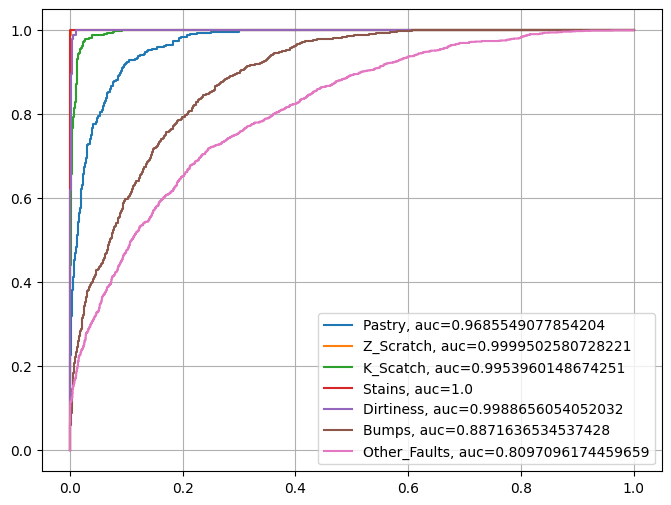

In [324]:
fig = plt.figure(figsize=(8,6))

results = pd.DataFrame()

for i, target in enumerate(TARGETS):
    y_true = y_test[target]
    y_pred_proba = models_lgbm[i].predict_proba(X_test)[::,1]
    results[target] = y_pred_proba
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_proba)
    auc = metrics.roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr,tpr,label=f"{target}, auc={auc}")
    plt.legend(loc=4)

plt.grid()
plt.show();

[LightGBM] [Warning] lambda_l2 is set=0.04503406239777487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04503406239777487
[LightGBM] [Warning] lambda_l1 is set=0.01681352088985483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01681352088985483


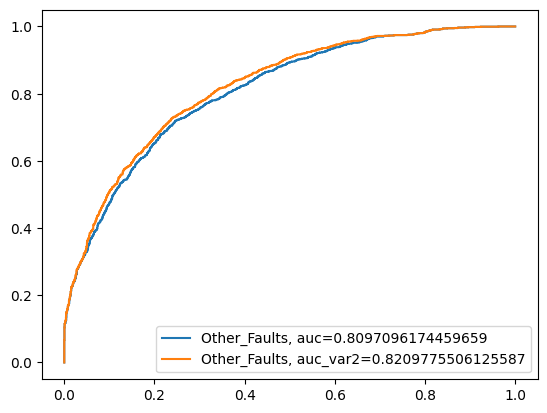

In [325]:
y_true = y_test[TARGETS[-1]]
y_pred_proba = models_lgbm[-1].predict_proba(X_test)[::,1]

y_pred_proba_var2 = results.apply(
    lambda row: row['Other_Faults']**1.05 if np.sum(row[TARGETS[:-1]]) >= 0.51 else row['Other_Faults']**0.95, 
    axis=1
)

fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_proba)
fpr_var2, tpr_var2, _ = metrics.roc_curve(y_true, y_pred_proba_var2)

auc = metrics.roc_auc_score(y_true, y_pred_proba)
auc_var2 = metrics.roc_auc_score(y_true, y_pred_proba_var2)
plt.plot(fpr,tpr,label=f"{TARGETS[-1]}, auc={auc}")
plt.plot(fpr_var2,tpr_var2,label=f"{TARGETS[-1]}, auc_var2={auc_var2}")
plt.legend(loc=4)

In [326]:
for i, model in enumerate(models_lgbm):
    subm_df[TARGETS[i]] = 1 - model.predict_proba(test_df_original[TRAIN_FEATURES])

[LightGBM] [Warning] lambda_l2 is set=0.039725039179295055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039725039179295055
[LightGBM] [Warning] lambda_l1 is set=0.007183121980905116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007183121980905116
[LightGBM] [Warning] lambda_l2 is set=0.02975549966080241, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02975549966080241
[LightGBM] [Warning] lambda_l1 is set=0.010109823217156623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010109823217156623
[LightGBM] [Warning] lambda_l2 is set=0.036875921079983796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.036875921079983796
[LightGBM] [Warning] lambda_l1 is set=0.010999173399538969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010999173399538969
[LightGBM] [Warning] lambda_l2 is set=0.044572021287035024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.044572021287035024
[LightGBM] [Warning] lambda_l1 is set=0

In [309]:
subm_df

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.46564,0.00091,0.00189,0.00001,0.01917,0.15383,0.27143
1,19220,0.20688,0.00701,0.00996,0.00001,0.07984,0.16606,0.33758
2,19221,0.00544,0.01565,0.03933,0.00002,0.00594,0.31904,0.50058
3,19222,0.13837,0.00121,0.00014,0.00027,0.01237,0.44546,0.42306
4,19223,0.00517,0.00175,0.00021,0.00012,0.00679,0.64750,0.36260
...,...,...,...,...,...,...,...,...
12809,32028,0.13884,0.01976,0.00183,0.00001,0.01536,0.18088,0.40707
12810,32029,0.12246,0.00145,0.01930,0.00210,0.08227,0.16084,0.45091
12811,32030,0.00217,0.00033,0.92095,0.00001,0.00090,0.00056,0.06797
12812,32031,0.38284,0.00431,0.02575,0.00001,0.04587,0.13954,0.30400


In [327]:
# collabrating other faults gives a better result

subm_df.Other_Faults = subm_df.drop(columns={'id'}).apply(
    lambda row: row['Other_Faults']**1.05 if np.sum(row[TARGETS[:-1]]) >= 0.51 else row['Other_Faults']**0.95, 
    axis=1
)

In [311]:
subm_df

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.46564,0.00091,0.00189,0.00001,0.01917,0.15383,0.25430
1,19220,0.20688,0.00701,0.00996,0.00001,0.07984,0.16606,0.35642
2,19221,0.00544,0.01565,0.03933,0.00002,0.00594,0.31904,0.51820
3,19222,0.13837,0.00121,0.00014,0.00027,0.01237,0.44546,0.40525
4,19223,0.00517,0.00175,0.00021,0.00012,0.00679,0.64750,0.34466
...,...,...,...,...,...,...,...,...
12809,32028,0.13884,0.01976,0.00183,0.00001,0.01536,0.18088,0.42578
12810,32029,0.12246,0.00145,0.01930,0.00210,0.08227,0.16084,0.46923
12811,32030,0.00217,0.00033,0.92095,0.00001,0.00090,0.00056,0.05942
12812,32031,0.38284,0.00431,0.02575,0.00001,0.04587,0.13954,0.28643


In [328]:
subm_df.to_csv('submission.csv', index=False)
!kaggle competitions submit -c playground-series-s4e3 -f submission.csv -m "optuna with new data, trained on full dataset, trials=30: 04.03.5"

100%|██████████████████████████████████████| 1.85M/1.85M [00:01<00:00, 1.37MB/s]
Successfully submitted to Steel Plate Defect Prediction

## Optuna CV

In [314]:
params_search = {
        "num_leaves": optuna.distributions.IntDistribution(70, 200), 
        "learning_rate": optuna.distributions.FloatDistribution(0.005, 0.03),
        "n_estimators": optuna.distributions.IntDistribution(400, 550),
        "lambda_l1": optuna.distributions.FloatDistribution(0.007, 0.017),
        "lambda_l2": optuna.distributions.FloatDistribution(0.02, 0.05),
        "max_depth": optuna.distributions.IntDistribution(6, 14),
        "colsample_bytree": optuna.distributions.FloatDistribution(0.1, 0.7),
        "subsample": optuna.distributions.FloatDistribution(0.7, 1.0),
        "min_child_samples": optuna.distributions.IntDistribution(20, 50)
    }

params_stable = {
    'objective': 'binary',
    "metric": "AUC",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "random_state": 42,
    "num_class": 1,
    'verbose': -1
}

In [315]:
models_lgbm = []
best_params_list = []

for target in TARGETS:
    print(f'{"="*20}{target}{"="*20}')
    
    model_os = LGBMClassifier(**params_stable)
    
    opt_search = optuna.integration.OptunaSearchCV(
        model_os, 
        params_search, 
        cv=5, 
        n_trials=30, 
        scoring='accuracy'
    )

    opt_search.fit(
        train_df_original[TRAIN_FEATURES], 
        train_df_original[target]
    )
    
    best_params = opt_search.best_params_
    best_params_list.append(best_params)
    
    model = LGBMClassifier(**best_params)
    model.fit(
        train_df_original[TRAIN_FEATURES], 
        train_df_original[target]
    )

    models_lgbm.append(model)

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2024-03-04 16:09:45,294] A new study created in memory with name: no-name-a9704efd-74e7-4456-a9eb-36455bacfa7d


====================Pastry====================


`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:09:46,969] Trial 0 finished with value: 0.925945179584121 and parameters: {'num_leaves': 101, 'learning_rate': 0.023057887953976376, 'n_estimators': 438, 'lambda_l1': 0.01653574223732639, 'lambda_l2': 0.02458746953655313, 'max_depth': 6, 'colsample_bytree': 0.35095635213868503, 'subsample': 0.7236534922763292, 'min_child_samples': 22}. Best is trial 0 with value: 0.925945179584121.
`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:09:49,687] Trial 1 finished with value: 0.925 and parameters: {'num_leaves': 76, 'learning_rate': 0.026447406919220776, 'n_estimators': 497, 'lambda_l1': 0.015141977959310614, 'lambda_l2': 0.03685914484068763, 'max_depth': 10, 'colsample_bytree': 0.180555625397733, 'subsample': 0.8455521599665456, 'min_child_samples': 20}. Best is trial 0 with value: 0.925945179584121.
`fit_pa

[LightGBM] [Warning] lambda_l2 is set=0.02458746953655313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02458746953655313
[LightGBM] [Warning] lambda_l1 is set=0.01653574223732639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01653574223732639
[LightGBM] [Warning] lambda_l2 is set=0.02458746953655313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02458746953655313
[LightGBM] [Warning] lambda_l1 is set=0.01653574223732639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01653574223732639
[LightGBM] [Info] Number of positive: 1624, number of negative: 19536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:BoostFrom

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2024-03-04 16:11:33,546] A new study created in memory with name: no-name-e8805b48-76c8-469d-bb08-bcaaf68af466


====================Z_Scratch====================


`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:11:37,519] Trial 0 finished with value: 0.9543005671077504 and parameters: {'num_leaves': 168, 'learning_rate': 0.028317828196453395, 'n_estimators': 532, 'lambda_l1': 0.016011787520695243, 'lambda_l2': 0.023766963605225386, 'max_depth': 9, 'colsample_bytree': 0.20541234576750655, 'subsample': 0.9172714357666757, 'min_child_samples': 33}. Best is trial 0 with value: 0.9543005671077504.
`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:11:42,461] Trial 1 finished with value: 0.9534971644612475 and parameters: {'num_leaves': 134, 'learning_rate': 0.01870779358990035, 'n_estimators': 504, 'lambda_l1': 0.013802111561504543, 'lambda_l2': 0.030970176185973346, 'max_depth': 11, 'colsample_bytree': 0.21548710755497896, 'subsample': 0.7381402944912723, 'min_child_samples': 22}. Best is trial 0 with value: 0.9543

[LightGBM] [Warning] lambda_l2 is set=0.039727032444828864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039727032444828864
[LightGBM] [Warning] lambda_l1 is set=0.00958779641863379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00958779641863379
[LightGBM] [Warning] lambda_l2 is set=0.039727032444828864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039727032444828864
[LightGBM] [Warning] lambda_l1 is set=0.00958779641863379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00958779641863379
[LightGBM] [Info] Number of positive: 1340, number of negative: 19820
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063327 -> initscore=-2.694022
[LightGBM] [Inf

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2024-03-04 16:13:23,008] A new study created in memory with name: no-name-b6d23b5c-ce93-4795-8af6-ba25b3c28594


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:13:26,783] Trial 0 finished with value: 0.9633270321361058 and parameters: {'num_leaves': 197, 'learning_rate': 0.02764560774262706, 'n_estimators': 412, 'lambda_l1': 0.016340870122830472, 'lambda_l2': 0.043987644060596146, 'max_depth': 14, 'colsample_bytree': 0.29149637269082274, 'subsample': 0.8873236831340658, 'min_child_samples': 37}. Best is trial 0 with value: 0.9633270321361058.
`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:13:30,038] Trial 1 finished with value: 0.963563327032136 and parameters: {'num_leaves': 172, 'learning_rate': 0.006797918785200567, 'n_estimators': 532, 'lambda_l1': 0.01446315916695913, 'lambda_l2': 0.04329070287938437, 'max_depth': 7, 'colsample_bytree': 0.6471063609770487, 'subsample': 0.95009606401614, 'min_child_samples': 23}. Best is trial 1 with value: 0.9635633270

[LightGBM] [Warning] lambda_l2 is set=0.02701114580184955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02701114580184955
[LightGBM] [Warning] lambda_l1 is set=0.011719317569075441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011719317569075441
[LightGBM] [Warning] lambda_l2 is set=0.02701114580184955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02701114580184955
[LightGBM] [Warning] lambda_l1 is set=0.011719317569075441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011719317569075441
[LightGBM] [Info] Number of positive: 3823, number of negative: 17337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.180671 -> initscore=-1.511807
[LightGBM] [Inf

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2024-03-04 16:15:06,518] A new study created in memory with name: no-name-49e19336-4edf-4148-957c-6c63ff399cb4


====================Stains====================


`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:15:08,032] Trial 0 finished with value: 0.9857750472589792 and parameters: {'num_leaves': 136, 'learning_rate': 0.017100930855867492, 'n_estimators': 431, 'lambda_l1': 0.007490083153940082, 'lambda_l2': 0.0325900792833657, 'max_depth': 6, 'colsample_bytree': 0.20732191728361798, 'subsample': 0.7347737100397712, 'min_child_samples': 30}. Best is trial 0 with value: 0.9857750472589792.
`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:15:11,323] Trial 1 finished with value: 0.9858223062381853 and parameters: {'num_leaves': 105, 'learning_rate': 0.008794759870733363, 'n_estimators': 516, 'lambda_l1': 0.009709770345775547, 'lambda_l2': 0.02072434801451765, 'max_depth': 13, 'colsample_bytree': 0.4991225316728439, 'subsample': 0.8883306063381171, 'min_child_samples': 32}. Best is trial 1 with value: 0.9858223

[LightGBM] [Warning] lambda_l2 is set=0.04702089156105432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04702089156105432
[LightGBM] [Warning] lambda_l1 is set=0.016124392761987252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016124392761987252
[LightGBM] [Warning] lambda_l2 is set=0.04702089156105432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04702089156105432
[LightGBM] [Warning] lambda_l1 is set=0.016124392761987252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016124392761987252
[LightGBM] [Info] Number of positive: 640, number of negative: 20520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:BoostF

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2024-03-04 16:16:12,290] A new study created in memory with name: no-name-16c86741-6b1a-4e2a-b236-20d2deae8695


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:16:16,009] Trial 0 finished with value: 0.9753780718336484 and parameters: {'num_leaves': 168, 'learning_rate': 0.02772612076282432, 'n_estimators': 423, 'lambda_l1': 0.012961863263705305, 'lambda_l2': 0.03098601561007449, 'max_depth': 14, 'colsample_bytree': 0.15639937326113346, 'subsample': 0.7910016694760351, 'min_child_samples': 32}. Best is trial 0 with value: 0.9753780718336484.
`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:16:21,664] Trial 1 finished with value: 0.9753308128544423 and parameters: {'num_leaves': 155, 'learning_rate': 0.027321123605181512, 'n_estimators': 536, 'lambda_l1': 0.016369316044516923, 'lambda_l2': 0.04805149495781899, 'max_depth': 12, 'colsample_bytree': 0.5376873189491981, 'subsample': 0.9979184061448142, 'min_child_samples': 27}. Best is trial 0 with value: 0.975378

[LightGBM] [Warning] lambda_l2 is set=0.040572138951026446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040572138951026446
[LightGBM] [Warning] lambda_l1 is set=0.014536441248659332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014536441248659332
[LightGBM] [Warning] lambda_l2 is set=0.040572138951026446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040572138951026446
[LightGBM] [Warning] lambda_l1 is set=0.014536441248659332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014536441248659332
[LightGBM] [Info] Number of positive: 540, number of negative: 20620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:Bo

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2024-03-04 16:17:57,278] A new study created in memory with name: no-name-c538e299-c24b-45e0-bd3b-bc761b27e933


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
====================Bumps====================


`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:18:03,043] Trial 0 finished with value: 0.7878071833648393 and parameters: {'num_leaves': 175, 'learning_rate': 0.016500436233244146, 'n_estimators': 482, 'lambda_l1': 0.015170498306824307, 'lambda_l2': 0.037906286158630474, 'max_depth': 12, 'colsample_bytree': 0.4777633239379391, 'subsample': 0.7411029116058638, 'min_child_samples': 45}. Best is trial 0 with value: 0.7878071833648393.
`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:18:05,940] Trial 1 finished with value: 0.7828922495274101 and parameters: {'num_leaves': 77, 'learning_rate': 0.005451015082191092, 'n_estimators': 490, 'lambda_l1': 0.015856621428141662, 'lambda_l2': 0.03248582952141604, 'max_depth': 7, 'colsample_bytree': 0.4018446615428829, 'subsample': 0.9567102296088765, 'min_child_samples': 38}. Best is trial 0 with value: 0.7878071

[LightGBM] [Warning] lambda_l2 is set=0.028689797772442842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028689797772442842
[LightGBM] [Warning] lambda_l1 is set=0.007462139921121422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007462139921121422
[LightGBM] [Warning] lambda_l2 is set=0.028689797772442842, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028689797772442842
[LightGBM] [Warning] lambda_l1 is set=0.007462139921121422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007462139921121422
[LightGBM] [Info] Number of positive: 5165, number of negative: 15995
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:B

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2024-03-04 16:19:50,278] A new study created in memory with name: no-name-14c44aff-a752-41d5-9bd3-cbde6a15475f


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
====================Other_Faults====================


`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:19:56,219] Trial 0 finished with value: 0.6882797731568997 and parameters: {'num_leaves': 84, 'learning_rate': 0.005686423493764163, 'n_estimators': 543, 'lambda_l1': 0.013846766159653827, 'lambda_l2': 0.04547142303832821, 'max_depth': 12, 'colsample_bytree': 0.6370675058160596, 'subsample': 0.9614729077813519, 'min_child_samples': 24}. Best is trial 0 with value: 0.6882797731568997.
`fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
[I 2024-03-04 16:20:01,359] Trial 1 finished with value: 0.6861058601134216 and parameters: {'num_leaves': 100, 'learning_rate': 0.017828960810911683, 'n_estimators': 485, 'lambda_l1': 0.013651480023670991, 'lambda_l2': 0.02686231364558734, 'max_depth': 12, 'colsample_bytree': 0.5156592635102127, 'subsample': 0.737136337196772, 'min_child_samples': 33}. Best is trial 0 with value: 0.68827977

[LightGBM] [Warning] lambda_l2 is set=0.026525436398292194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026525436398292194
[LightGBM] [Warning] lambda_l1 is set=0.011492871078635801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011492871078635801
[LightGBM] [Warning] lambda_l2 is set=0.026525436398292194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026525436398292194
[LightGBM] [Warning] lambda_l1 is set=0.011492871078635801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011492871078635801
[LightGBM] [Info] Number of positive: 7231, number of negative: 13929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5275
[LightGBM] [Info] Number of data points in the train set: 21160, number of used features: 27
[LightGBM] [Info] [binary:B

[LightGBM] [Warning] lambda_l2 is set=0.02458746953655313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02458746953655313
[LightGBM] [Warning] lambda_l1 is set=0.01653574223732639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01653574223732639
[LightGBM] [Warning] lambda_l2 is set=0.039727032444828864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039727032444828864
[LightGBM] [Warning] lambda_l1 is set=0.00958779641863379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00958779641863379
[LightGBM] [Warning] lambda_l2 is set=0.02701114580184955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02701114580184955
[LightGBM] [Warning] lambda_l1 is set=0.011719317569075441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011719317569075441
[LightGBM] [Warning] lambda_l2 is set=0.04702089156105432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04702089156105432
[LightGBM] [Warning] lambda_l1 is set=0.0161243

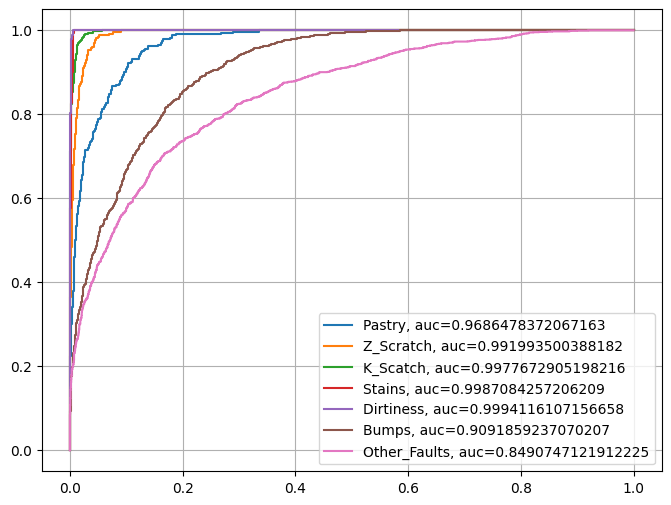

In [316]:
fig = plt.figure(figsize=(8,6))

results = pd.DataFrame()

for i, target in enumerate(TARGETS):
    y_true = y_test[target]
    y_pred_proba = models_lgbm[i].predict_proba(X_test)[::,1]
    results[target] = y_pred_proba
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_proba)
    auc = metrics.roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr,tpr,label=f"{target}, auc={auc}")
    plt.legend(loc=4)

plt.grid()
plt.show();

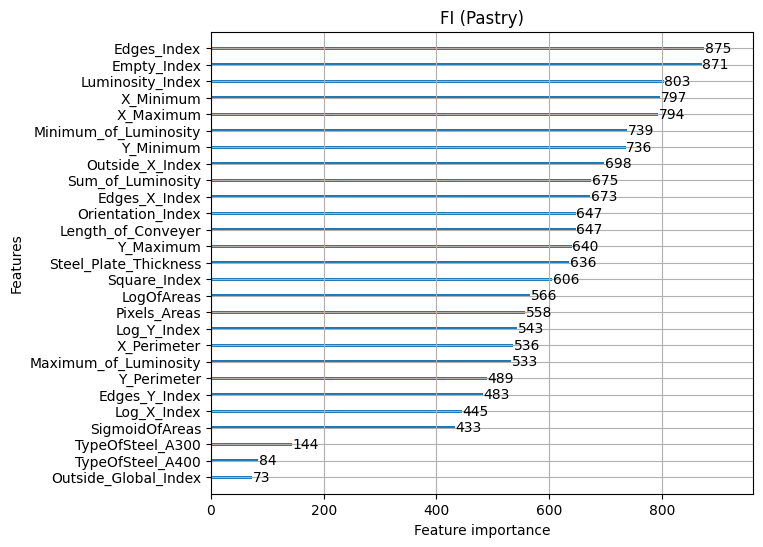

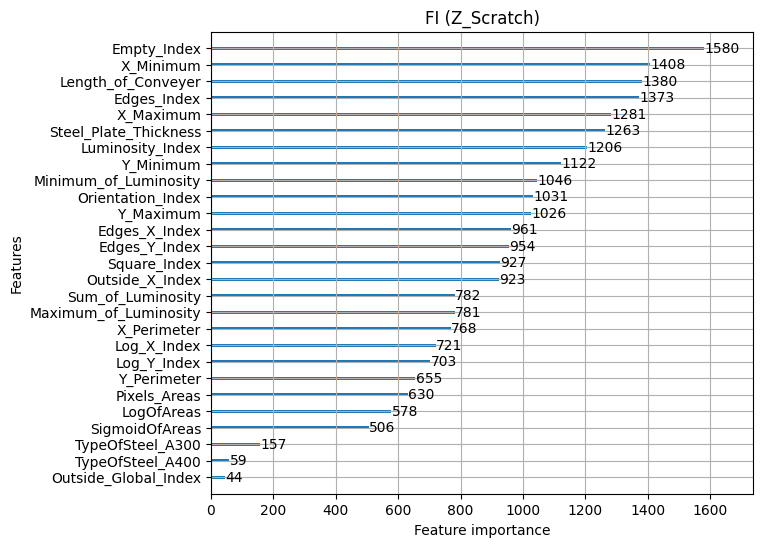

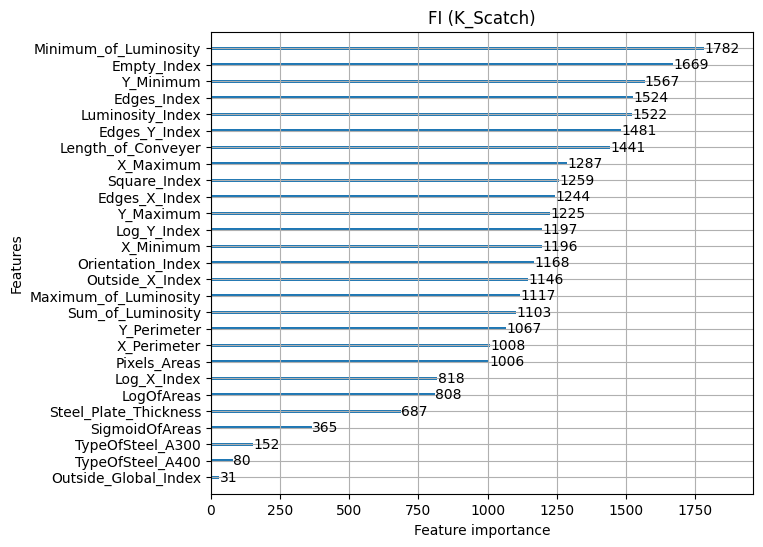

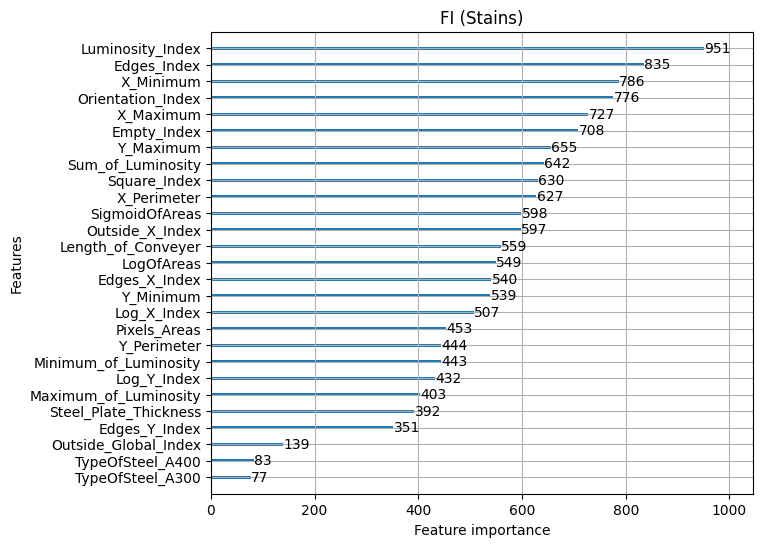

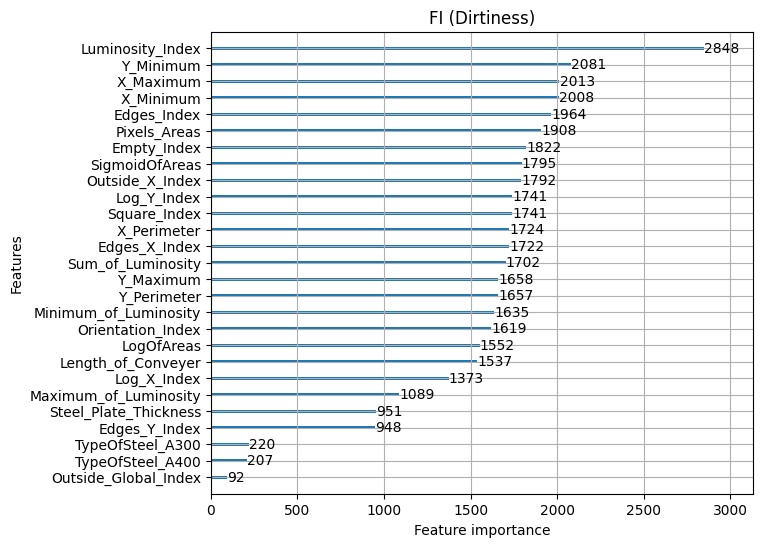

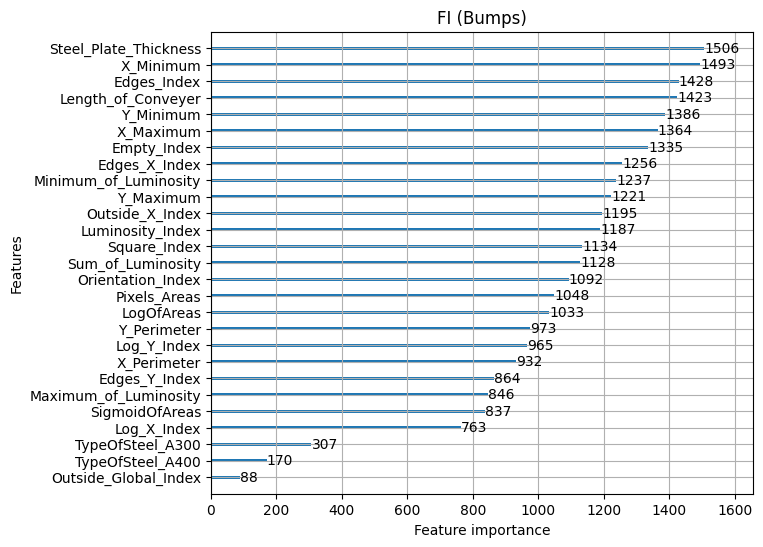

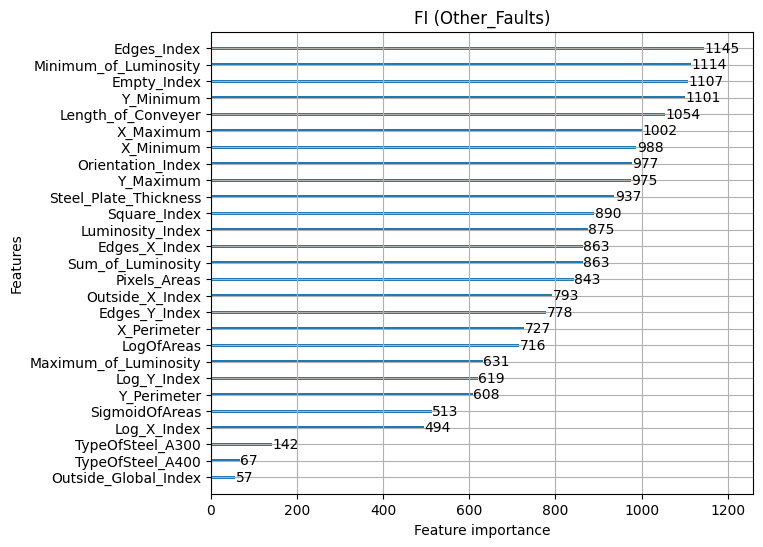

In [317]:
for i, model in enumerate(models_lgbm):
    lgb.plot_importance(model, importance_type="split", figsize=(7,6), title=f"FI ({TARGETS[i]})")
    plt.show()

[LightGBM] [Warning] lambda_l2 is set=0.026525436398292194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026525436398292194
[LightGBM] [Warning] lambda_l1 is set=0.011492871078635801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011492871078635801


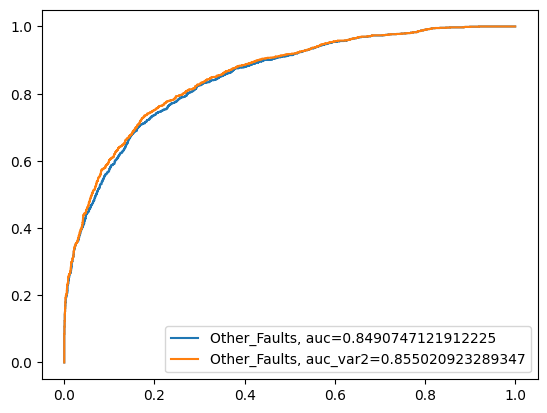

In [318]:
y_true = y_test[TARGETS[-1]]
y_pred_proba = models_lgbm[-1].predict_proba(X_test)[::,1]

y_pred_proba_var2 = results.apply(
    lambda row: row['Other_Faults']**1.05 if np.sum(row[TARGETS[:-1]]) >= 0.51 else row['Other_Faults']**0.95, 
    axis=1
)

fpr, tpr, _ = metrics.roc_curve(y_true, y_pred_proba)
fpr_var2, tpr_var2, _ = metrics.roc_curve(y_true, y_pred_proba_var2)

auc = metrics.roc_auc_score(y_true, y_pred_proba)
auc_var2 = metrics.roc_auc_score(y_true, y_pred_proba_var2)
plt.plot(fpr,tpr,label=f"{TARGETS[-1]}, auc={auc}")
plt.plot(fpr_var2,tpr_var2,label=f"{TARGETS[-1]}, auc_var2={auc_var2}")
plt.legend(loc=4)

In [319]:
for i, model in enumerate(models_lgbm):
    subm_df[TARGETS[i]] = 1 - model.predict_proba(test_df_original[TRAIN_FEATURES])

[LightGBM] [Warning] lambda_l2 is set=0.02458746953655313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02458746953655313
[LightGBM] [Warning] lambda_l1 is set=0.01653574223732639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01653574223732639
[LightGBM] [Warning] lambda_l2 is set=0.039727032444828864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039727032444828864
[LightGBM] [Warning] lambda_l1 is set=0.00958779641863379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00958779641863379
[LightGBM] [Warning] lambda_l2 is set=0.02701114580184955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02701114580184955
[LightGBM] [Warning] lambda_l1 is set=0.011719317569075441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011719317569075441
[LightGBM] [Warning] lambda_l2 is set=0.04702089156105432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04702089156105432
[LightGBM] [Warning] lambda_l1 is set=0.0161243

In [320]:
subm_df.Other_Faults = subm_df.drop(columns={'id'}).apply(
    lambda row: row['Other_Faults']**1.05 if np.sum(row[TARGETS[:-1]]) >= 0.51 else row['Other_Faults']**0.95, 
    axis=1
)

In [321]:
subm_df

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.63449,0.00083,0.00079,0.00009,0.01052,0.14778,0.37197
1,19220,0.26989,0.00961,0.00369,0.00024,0.07197,0.17964,0.30460
2,19221,0.00061,0.03355,0.04795,0.00069,0.00256,0.27960,0.50582
3,19222,0.22359,0.00085,0.00021,0.00151,0.00754,0.44946,0.42460
4,19223,0.00155,0.00197,0.00024,0.00310,0.00305,0.64162,0.31361
...,...,...,...,...,...,...,...,...
12809,32028,0.03764,0.06130,0.00078,0.00013,0.01041,0.19410,0.40552
12810,32029,0.16945,0.00239,0.02072,0.01286,0.07354,0.21484,0.43963
12811,32030,0.00010,0.00033,0.93977,0.00005,0.00034,0.00069,0.05923
12812,32031,0.35332,0.01049,0.01155,0.00010,0.03852,0.13668,0.28736


In [322]:
subm_df.to_csv('submission.csv', index=False)
!kaggle competitions submit -c playground-series-s4e3 -f submission.csv -m "optunaCV trials=30: 04.03.4"

100%|███████████████████████████████████████| 1.86M/1.86M [00:02<00:00, 952kB/s]
Successfully submitted to Steel Plate Defect Prediction

## Other faults comparison of models

In [188]:
train_df_other_faults = train_df_original.iloc[~train_df_original.index.isin(outliers_dfs.index)]

In [189]:
train_df_other_faults.shape, train_df_original.shape

((19092, 34), (19219, 34))

In [194]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df_original[TRAIN_FEATURES], 
    train_df_original[TARGETS], 
    test_size=0.2, 
    random_state=42
)

In [193]:
X_train_z, X_test_z, y_train_z, y_test_z = train_test_split(
    train_df_other_faults[TRAIN_FEATURES], 
    train_df_other_faults[TARGETS], 
    test_size=0.2, 
    random_state=42
)

In [ ]:
target = 'Other_Faults'

print(f'{"="*20}{target}{"="*20}')

sampler = optuna.samplers.TPESampler(seed=42) 

study = optuna.create_study(direction="maximize", sampler=sampler)    
study.optimize(
    lambda trial: 
        objective(
            trial, 
            X_train, 
            y_train[target], 
            X_test, 
            y_test[target]
        ), 
        n_trials=30
)

best_params = study.best_params
best_params_list.append(best_params)

In [ ]:
model = LGBMClassifier(**best_params)
model.fit(
    X_train[TRAIN_FEATURES], 
    y_train[target]
)

In [ ]:
target = 'Other_Faults'

print(f'{"="*20}{target}{"="*20}')

sampler = optuna.samplers.TPESampler(seed=42) 

study = optuna.create_study(direction="maximize", sampler=sampler)    
study.optimize(
    lambda trial: 
        objective(
            trial, 
            X_train_z, 
            y_train_z[target], 
            X_test_z, 
            y_test_z[target]
        ), 
        n_trials=30
)

best_params_z = study.best_params

In [ ]:
model_z = LGBMClassifier(**best_params_z)
model_z.fit(
    X_train_z[TRAIN_FEATURES], 
    y_train_z[target]
)

[LightGBM] [Warning] lambda_l2 is set=0.041929995692820465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.041929995692820465
[LightGBM] [Warning] lambda_l1 is set=0.007074039062225321, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007074039062225321


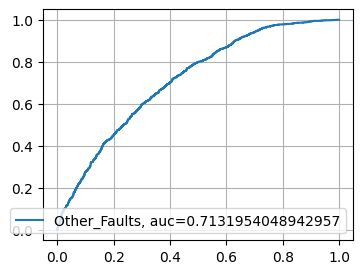

In [206]:
# baseline catboost

fig = plt.figure(figsize=(4,3))

results = pd.DataFrame()

for i, target in enumerate([TARGETS[-1]]):
    y_true = y_test[target]
    y_pred_proba = model.predict_proba(X_test)[::,1]
    results[target] = y_pred_proba
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_proba)
    auc = metrics.roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr,tpr,label=f"{target}, auc={auc}")
    plt.legend(loc=4)

plt.grid()
plt.show();

[LightGBM] [Warning] lambda_l2 is set=0.039811097223146845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039811097223146845
[LightGBM] [Warning] lambda_l1 is set=0.011308730617386553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011308730617386553


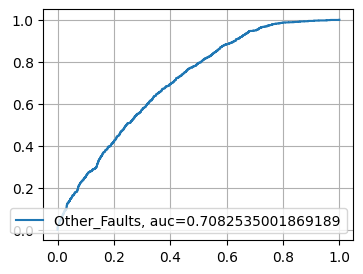

In [250]:
# baseline catboost

fig = plt.figure(figsize=(4,3))

results = pd.DataFrame()

for i, target in enumerate([TARGETS[-1]]):
    y_true = y_test_z[target]
    y_pred_proba = model_z.predict_proba(X_test_z)[::,1]
    results[target] = y_pred_proba
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_proba)
    auc = metrics.roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr,tpr,label=f"{target}, auc={auc}")
    plt.legend(loc=4)

plt.grid()
plt.show();

In [218]:
results.shape

(3844, 7)

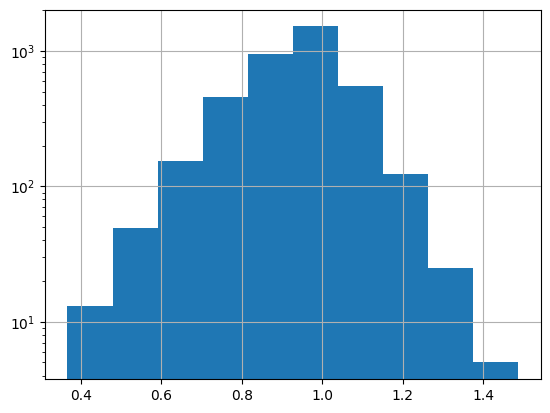

In [248]:
np.sum(results, axis=1).hist(log=True);

In [247]:
np.sum(train_df_original[TARGETS], axis=1).value_counts()

1    18380
0      818
2       21
Name: count, dtype: int64